In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [5]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [6]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

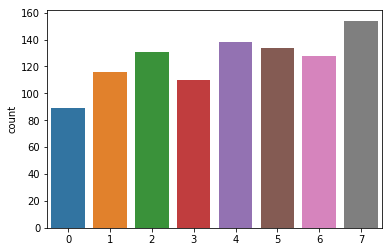

In [6]:
sns.countplot(Z_train)
plt.show()

### Load annotations / Generate

In [6]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [17]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

(1000, 2547)

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [9]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

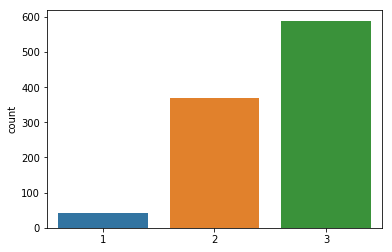

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


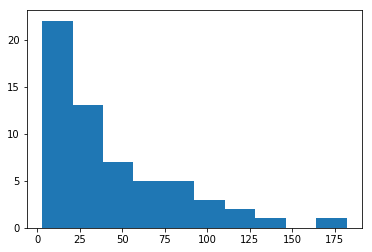

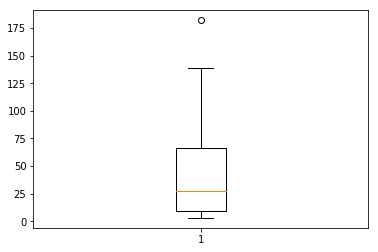

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182
Mean annotations by an annotator:  43.16949152542373


In [8]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 22


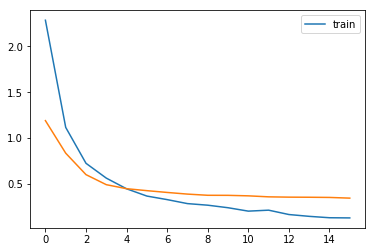

In [46]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [9]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.024505 sec
Representation for DS in 0.015270 sec
Estimation MV in 0.000551 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.162201687051
2 	 -2760.563771697602 	0.0216	0.166209	0.026998
3 	 -2734.5908131797937 	0.0124	0.062463	0.009409
4 	 -2723.3804054466614 	0.0073	0.061532	0.004099
5 	 -2717.7194863819373 	0.0045	0.054811	0.002079
6 	 -2714.5174717248647 	0.0031	0.043390	0.001178
7 	 -2712.672927950991 	0.0022	0.033013	0.000680
8 	 -2711.508833691413 	0.0017	0.026319	0.000429
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]
Estimation for DS in 2.394502 sec


In [12]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [13]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [14]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 8


In [19]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 16


In [21]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 9


### Raykar Model (joint predict model)

In [25]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 2547, 8)


In [26]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.46 sec)	logL: -4441.701	
Iter 2/50 
M step: done,  E step: done //  (in 0.26 sec)	logL: -4198.188	Tol1: 0.05482	Tol2: 0.01469	
Iter 3/50 
M step: done,  E step: done //  (in 0.27 sec)	logL: -4108.247	Tol1: 0.02142	Tol2: 0.00528	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.13 sec)	logL: -4463.614	
Iter 2/50 
M step: done,  E step: done //  (in 0.25 sec)	logL: -4194.899	Tol1: 0.06020	Tol2: 0.01544	
Iter 3/50 
M step: done,  E step: done //  (in 0.26 sec)	logL: -4082.526	Tol1: 0.02679	Tol2: 0.00575	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.10 sec)	logL: -4483.836	
Iter 2/50 
M step: done,  E step: done //  (in 0.26 sec)	logL: 

In [27]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test)

Bayesian gaussian mixture say is 20 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt

DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (5197, 4)


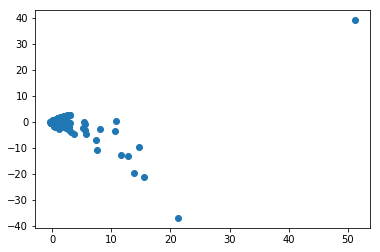

In [12]:
## cluster annotations?
from sklearn.preprocessing import StandardScaler
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

### Our Proposed

In [27]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [28]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


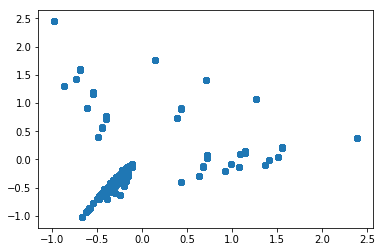

In [10]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005396 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7649964  0.35427967 0.05306005 0.08938941 0.32689986]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.57 sec)	logL: -7404.934	
Finished training!


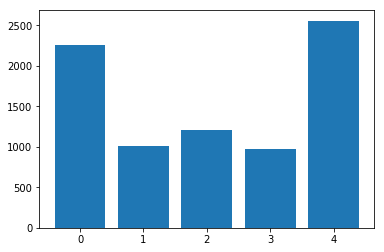

<BarContainer object of 5 artists>

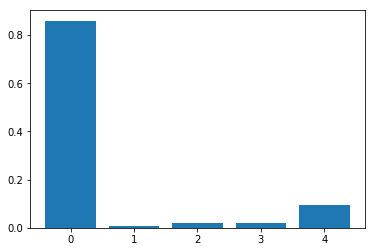

In [16]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [31]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003649 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3260.276	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2203.735	Tol1: 0.32406	Tol2: 0.70936	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.212	Tol1: 0.09825	Tol2: 0.15927	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1902.811	Tol1: 0.04247	Tol2: 0.11973	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.444	Tol1: 0.02594	Tol2: 0.06754	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1775.781	Tol1: 0.04190	Tol2: 0.05046	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL:

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003971 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.59]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3011.392	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2115.873	Tol1: 0.29738	Tol2: 0.39124	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1924.810	Tol1: 0.09030	Tol2: 0.18874	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.941	Tol1: 0.03682	Tol2: 0.14168	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.691	Tol1: 0.04005	Tol2: 0.10433	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1732.332	Tol1: 0.02661	Tol2: 0.07472	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL:

/users/fmena/MixtureofGroups/code/utils.py:285: RuntimeWarning: invalid value encountered in true_divide
  entropy_values = [entropy(value)/np.log(len(value)) for value in probas_Mchange]


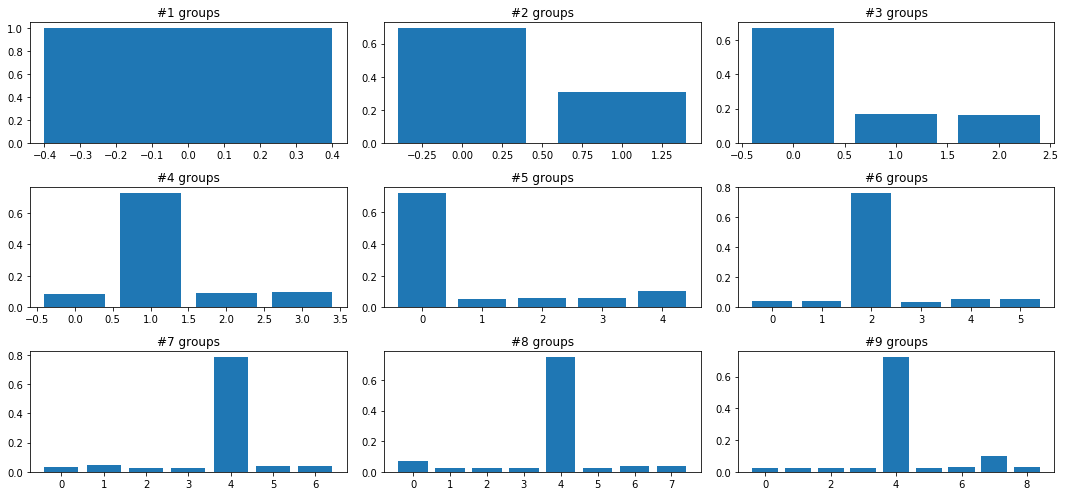

<Figure size 1080x360 with 0 Axes>

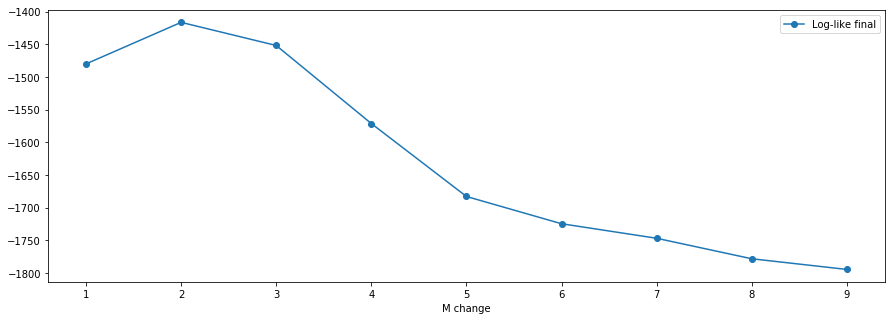

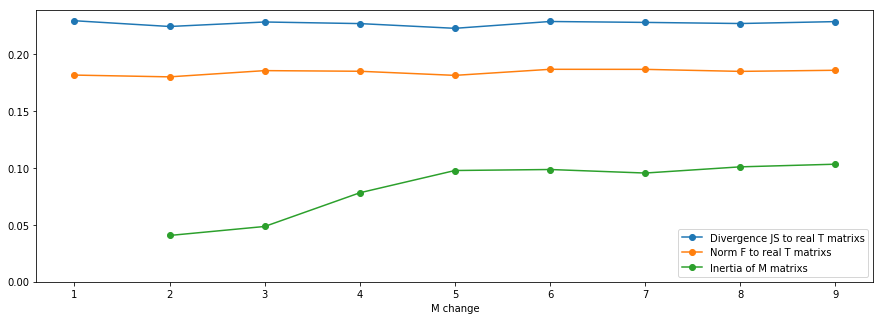

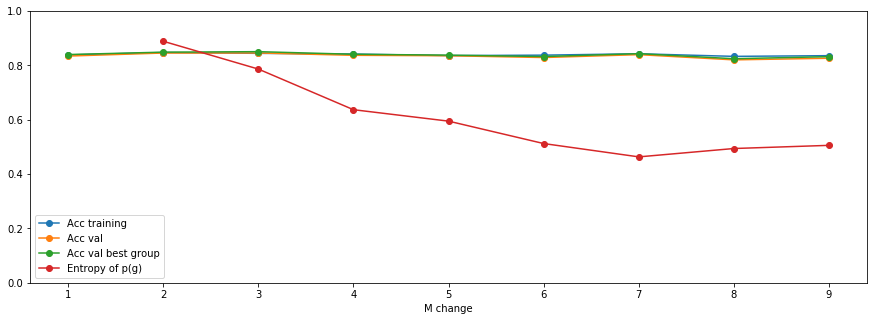

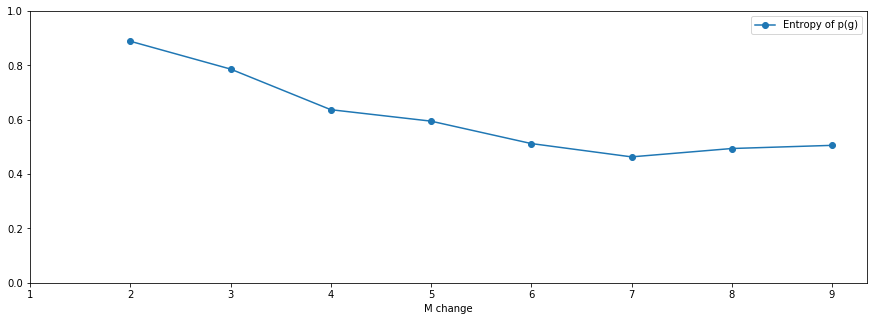

In [32]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [17]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

59


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0        1              1              1                   1   
1        2              1              1                   1   
2        3              1              1                   1   
3        4              2              1                   1   
4        5              1              1                   1   
5        6              1              1                   1   
6        7              2              1                   1   
7        8              2              2                   1   
8        9              2              1                   1   

   Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                1                                1  
1                                1                                1  
2                                1                                1  
3                                2                                1  
4                                1                                1  
5                                1                                1  
6                                2                                1  
7                                2                                2  
8                                2                                1

1, 2 o 3...

In [25]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [26]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.004702 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.92 sec)	logL: -2840.796	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2119.235	Tol1: 0.25400	Tol2: 0.33181	Tol3: 0.03026	
Iter 3/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1952.185	Tol1: 0.07883	Tol2: 0.13793	Tol3: 0.23519	
Iter 4/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1862.488	Tol1: 0.04595	Tol2: 0.08270	Tol3: 0.22889	
Iter 5/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1787.467	Tol1: 0.04028	Tol2: 0.05432	Tol3: 0.21979	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1737.229	Tol1: 0.02811	Tol2: 0.03847	Tol3: 0.20960	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1691.302	Tol1: 0.02644	Tol2: 0.03213	Tol3: 0.18258	
Iter 8

M step: done,  E step: done //  (in 0.57 sec)	logL: -2875.362	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2134.254	Tol1: 0.25774	Tol2: 0.27438	Tol3: 0.05470	
Iter 3/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1958.437	Tol1: 0.08238	Tol2: 0.14381	Tol3: 0.23082	
Iter 4/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1872.111	Tol1: 0.04408	Tol2: 0.07852	Tol3: 0.20813	
Iter 5/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1804.774	Tol1: 0.03597	Tol2: 0.05954	Tol3: 0.19133	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1745.070	Tol1: 0.03308	Tol2: 0.04972	Tol3: 0.17998	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1698.472	Tol1: 0.02670	Tol2: 0.03725	Tol3: 0.16586	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1670.472	Tol1: 0.01649	Tol2: 0.02109	Tol3: 0.14055	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.004764 mins
Lambda by group:  [1. 1. 1.]
Alp

M step: done,  E step: done //  (in 0.64 sec)	logL: -3275.050	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2276.345	Tol1: 0.30494	Tol2: 0.29885	Tol3: 0.05384	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1986.959	Tol1: 0.12713	Tol2: 0.14216	Tol3: 0.24285	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1859.375	Tol1: 0.06421	Tol2: 0.09622	Tol3: 0.23475	
Iter 5/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1783.878	Tol1: 0.04060	Tol2: 0.07852	Tol3: 0.21547	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1734.609	Tol1: 0.02762	Tol2: 0.04627	Tol3: 0.20479	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1706.043	Tol1: 0.01647	Tol2: 0.03720	Tol3: 0.17710	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1662.679	Tol1: 0.02542	Tol2: 0.02832	Tol3: 0.13367	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.004330 mins
Lambda by group:  [1. 1. 1.]
Alp

In [26]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

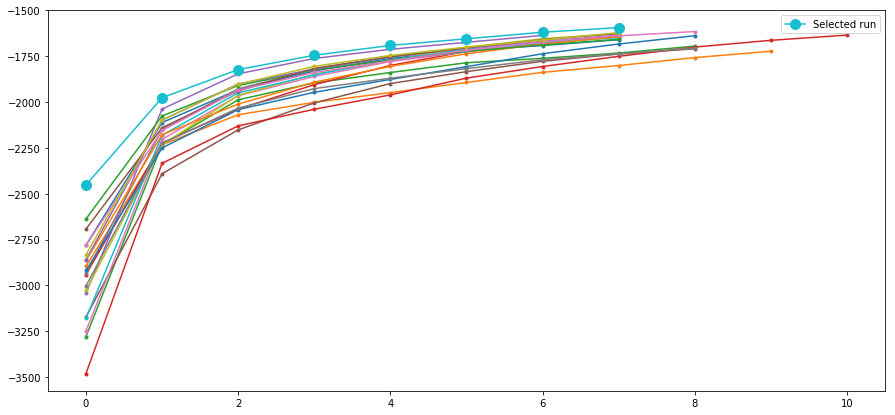

In [16]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [11]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (59, 59)


shape of annotator representation (T, R_t)= (59, 64)


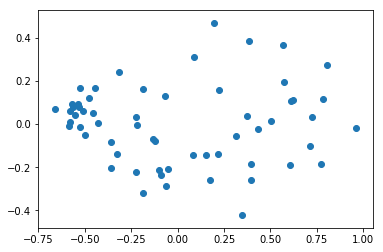

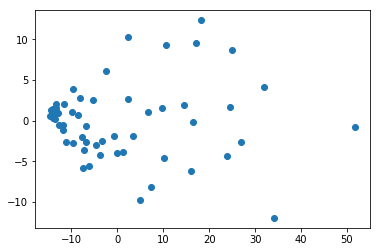

array([[ 7., 17., 10., 11., 15., 13., 25., 10.],
       [ 2.,  0.,  0.,  3.,  1.,  2.,  2.,  2.],
       [ 4.,  9., 10.,  8.,  4., 11., 16.,  8.],
       [ 6.,  0., 11., 11.,  3.,  4., 11.,  4.],
       [ 4., 11., 15., 10., 20.,  4., 17.,  4.],
       [ 4.,  6., 12.,  5.,  9., 10.,  9.,  7.],
       [ 9., 15.,  8.,  7., 11., 16., 14., 11.],
       [ 1.,  0., 10.,  5.,  2., 10.,  5.,  2.],
       [ 2.,  4.,  2.,  3.,  3.,  4.,  4.,  3.],
       [ 2., 11.,  8.,  4., 13., 10., 15.,  5.],
       [11., 16., 19., 14., 25., 10., 14., 11.],
       [11., 13., 15., 15., 16., 15., 20.,  5.],
       [ 1.,  6.,  0.,  3.,  2.,  2.,  2.,  1.],
       [ 2.,  9.,  2.,  0.,  4.,  1.,  4.,  1.],
       [ 4.,  8.,  2.,  0.,  6.,  2.,  4.,  2.],
       [ 4., 18., 10.,  3.,  6.,  6., 13.,  4.],
       [ 6.,  3., 15., 16., 16., 22., 19., 13.],
       [ 6.,  4., 15., 20.,  7., 14., 18.,  8.],
       [ 5.,  6., 13., 18.,  8., 10., 21.,  7.],
       [ 9., 26., 11., 14., 20., 25., 20., 14.],
       [ 7., 23., 23

In [56]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
#A_rep = np.zeros((conf_mat.shape[0], Kl))
#for t in range(A_rep.shape[0]):
#    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [57]:
#different M_seted??
M_seted = 3

In [65]:
gMixture_Ind1 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("mlp",128,1,BatchN=False,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i = gMixture_Ind1.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000517 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -2090.210	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1784.161	Tol1: 0.14642	Tol2: 0.37931	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1659.132	Tol1: 0.07008	Tol2: 0.12435	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1601.060	Tol1: 0.03500	Tol2: 0.05993	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1559.010	Tol1: 0.02626	Tol2: 0.03942	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1518.095	Tol1: 0.02624	Tol2: 0.03269	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1492.839	Tol1: 0.01664	Tol2: 0.02964	
Finished trai

M step: done,  E step: done //  (in 0.07 sec)	logL: -1634.803	Tol1: 0.06960	Tol2: 0.12149	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1578.388	Tol1: 0.03451	Tol2: 0.05646	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1537.892	Tol1: 0.02566	Tol2: 0.03277	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1505.739	Tol1: 0.02091	Tol2: 0.02169	
Finished training!
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000470 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 1.34 sec)	logL: -2028.905	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1784.766	Tol1: 0.12033	Tol2: 0.38221	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1652.884	Tol1: 0.07389	Tol2: 0.12994	
Iter 4/50
M step: done,  E step: done //  (i

In [62]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [ ]:
gMixture_Ind2 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("mlp",128,1,BatchN=False,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i = gMixture_Ind2.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

In [27]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000291 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 1.16 sec)	logL: -1924.714	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1691.273	Tol1: 0.12129	Tol2: 1.13136	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1570.014	Tol1: 0.07170	Tol2: 0.17210	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1506.061	Tol1: 0.04073	Tol2: 0.06914	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1459.140	Tol1: 0.03115	Tol2: 0.04374	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1418.060	Tol1: 0.02815	Tol2: 0.02816	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000266 mins
Lambda by group:  [

M step: done,  E step: done //  (in 0.10 sec)	logL: -1710.078	Tol1: 0.07374	Tol2: 0.13356	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1622.380	Tol1: 0.05128	Tol2: 0.09432	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1554.664	Tol1: 0.04174	Tol2: 0.04942	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1514.852	Tol1: 0.02561	Tol2: 0.04848	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1482.629	Tol1: 0.02127	Tol2: 0.04166	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1452.544	Tol1: 0.02029	Tol2: 0.04620	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1423.830	Tol1: 0.01977	Tol2: 0.04034	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1400.023	Tol1: 0.01672	Tol2: 0.03569	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1381.570	Tol1: 0.01318	Tol2: 0.03479	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1359.022	Tol1: 0.01632	Tol2: 0.0377

In [28]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

### Rodrigues

In [199]:
from code.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy

#need input in rodrigues represnetation format, output shape = (N,K, T)
y_obs_catmasked = set_representation(y_obs, 'onehotmasked')
print("shape:",y_obs_catmasked.shape)

shape: (1000, 8, 59)


In [200]:
#TOL = 3e-3 #cambio en la tol
TOL = 1e-2
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

In [201]:
model_crowdL = clone_UB.get_model()
model_crowdL.add(CrowdsClassification(Kl, T, conn_type="MW")) #confusion matrix set

# instantiate specialized masked loss to handle missing answers
loss = MaskedMultiCrossEntropy().loss
model_crowdL.compile(loss=loss, optimizer=OPT)

hist = model_crowdL.fit(Xstd_train, y_obs_catmasked, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
prob_Yxt = model_crowdL.predict(Xstd_train).transpose([0,2,1]) #sale de arriba

Epoch 1/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0879
Epoch 2/50
1000/1000 [==============================] - 0s 87us/step - loss: 0.0794
Epoch 3/50
1000/1000 [==============================] - 0s 101us/step - loss: 0.0751
Epoch 4/50
1000/1000 [==============================] - 0s 91us/step - loss: 0.0730
Epoch 5/50
1000/1000 [==============================] - 0s 104us/step - loss: 0.0701
Epoch 6/50
1000/1000 [==============================] - 0s 65us/step - loss: 0.0686
Epoch 7/50
1000/1000 [==============================] - 0s 80us/step - loss: 0.0678
Epoch 8/50
1000/1000 [==============================] - 0s 75us/step - loss: 0.0666
Epoch 9/50
1000/1000 [==============================] - 0s 60us/step - loss: 0.0662
Trained model over hard-MV, Epochs to converge = 9


In [213]:
from keras import backend as K
import tensorflow as tf

def loss_prior_MV(p_z):
    def loss(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, -1), K.floatx())
        r_obs = K.sum(y_true*mask, axis=-1)
        mv = r_obs/K.sum(r_obs,axis=-1, keepdims=True) #on batch size.. (all annotators)

        p_z_clip = K.clip(p_z, K.epsilon(), 1)
        mv = K.clip(mv, K.epsilon(), 1)
        KL_mv = K.sum(p_z_clip* K.log(p_z_clip/mv), axis=-1)
    
        #maskedmulti cross entropy
        vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, dim=1)
        mask = tf.equal(y_true[:,0,:], -1) 
        zer = tf.zeros_like(vec)
        loss_masked = K.mean( tf.where(mask, x=zer, y=vec), axis=-1)
        return loss_masked + KL_mv
    return loss


model_crowdL = clone_UB.get_model()
model_crowdL.add(CrowdsClassification(Kl, T, conn_type="MW")) #confusion matrix set

#add prior --variation
out_z = model_crowdL.layers[-2].output
loss = loss_prior_MV(out_z)
model_crowdL.compile(loss=loss, optimizer=OPT)

hist = model_crowdL.fit(Xstd_train, y_obs_catmasked, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
prob_Yxt = model_crowdL.predict(Xstd_train).transpose([0,2,1]) #sale de arriba

Epoch 1/50
1000/1000 [==============================] - 3s 3ms/step - loss: 10.0899
Epoch 2/50
1000/1000 [==============================] - 0s 78us/step - loss: 6.9642
Epoch 3/50
1000/1000 [==============================] - 0s 85us/step - loss: 5.6773
Epoch 4/50
1000/1000 [==============================] - 0s 114us/step - loss: 4.7066
Epoch 5/50
1000/1000 [==============================] - 0s 93us/step - loss: 3.6604
Epoch 6/50
1000/1000 [==============================] - 0s 98us/step - loss: 2.9888
Epoch 7/50
1000/1000 [==============================] - 0s 112us/step - loss: 2.3056
Epoch 8/50
1000/1000 [==============================] - 0s 93us/step - loss: 2.2464
Epoch 9/50
1000/1000 [==============================] - 0s 84us/step - loss: 2.2417
Trained model over hard-MV, Epochs to converge = 9


In [214]:
weights = model_crowdL.layers[-1].get_weights()[0] # save weights from crowds layer for later
crowdL_conf = weights.transpose([2,0,1])
model_crowdL.pop() 

Z_train_pred = model_crowdL.predict_classes(Xstd_train)
Z_test_pred = model_crowdL.predict_classes(Xstd_test)

*** CrowdLayer (Rodrigues et al.) ***
Train
Calculate confusion matrix on repeat version


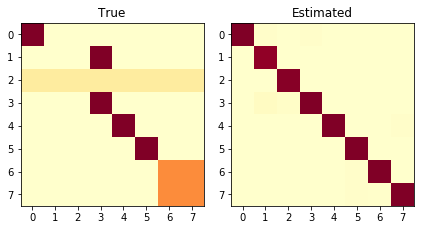

JS divergence: 0.2953	Norm Frobenius: 0.2476


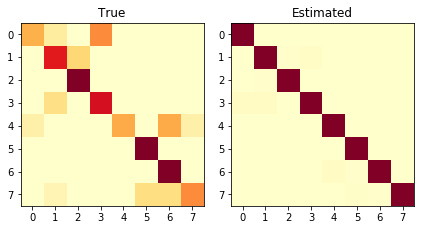

JS divergence: 0.1623	Norm Frobenius: 0.1738


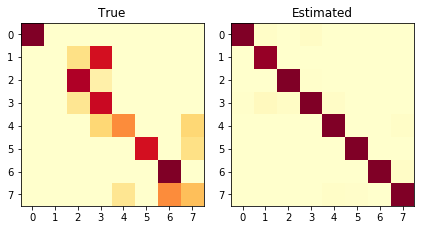

JS divergence: 0.2459	Norm Frobenius: 0.2203


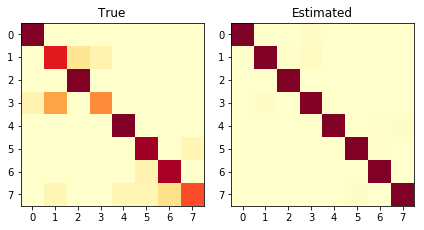

JS divergence: 0.0800	Norm Frobenius: 0.1181


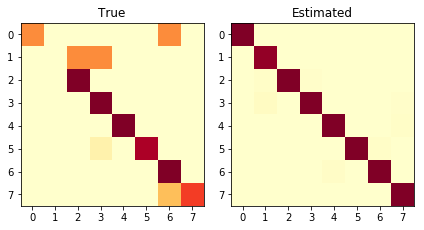

JS divergence: 0.2003	Norm Frobenius: 0.1921


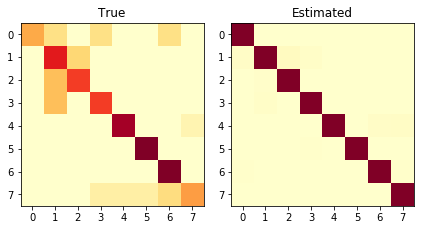

JS divergence: 0.1487	Norm Frobenius: 0.1578


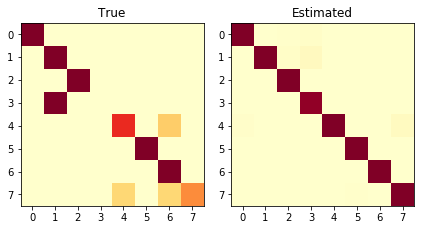

JS divergence: 0.1902	Norm Frobenius: 0.2038


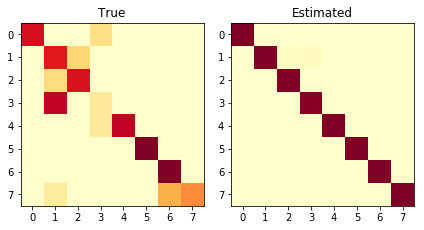

JS divergence: 0.1762	Norm Frobenius: 0.1957


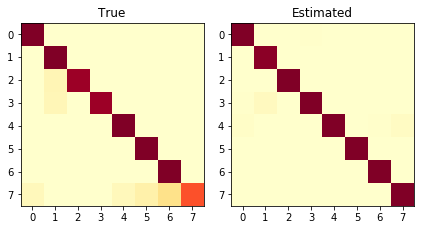

JS divergence: 0.0354	Norm Frobenius: 0.0760


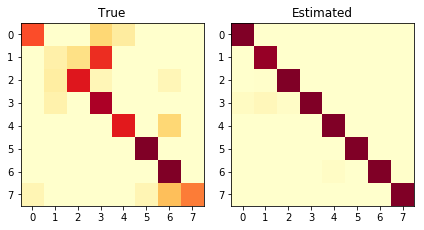

JS divergence: 0.1943	Norm Frobenius: 0.1879


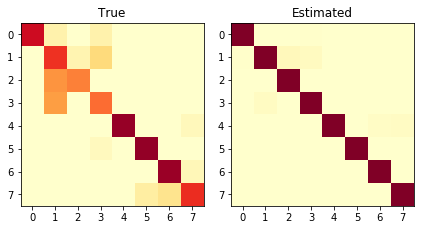

JS divergence: 0.1097	Norm Frobenius: 0.1480


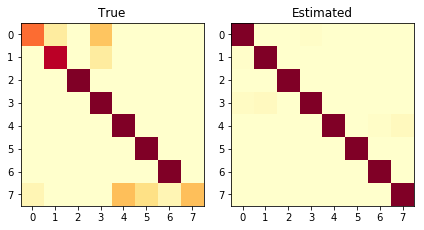

JS divergence: 0.1015	Norm Frobenius: 0.1309


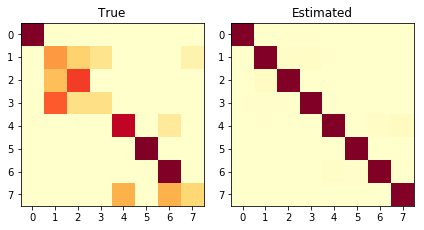

JS divergence: 0.1975	Norm Frobenius: 0.2039


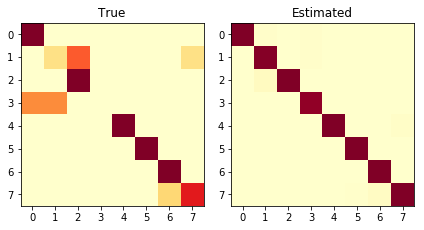

JS divergence: 0.2171	Norm Frobenius: 0.2050


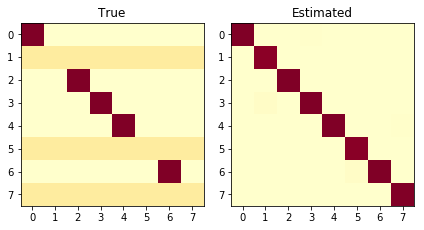

JS divergence: 0.2722	Norm Frobenius: 0.2037
Calculate confusion matrix on global version


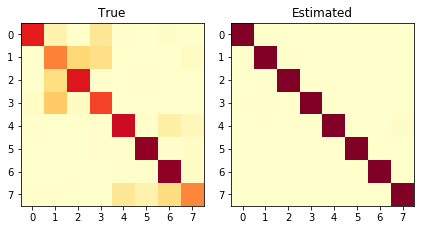

JS divergence: 0.1414	Norm Frobenius: 0.1371
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All     0.855       0.855       0.853          0.2248       0.2866   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0       0.1767     0.174     0.1371  0.1414     0.1573  0.1174

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A result


ACC imiting Annot mean  F1-mi imiting Annot mean  F1-ma imiting Annot mean  \
0                  0.7517                    0.7517                    0.6935   

   ACC imiting Annot wmean  F1-mi imiting Annot wmean  \
0                   0.7633                     0.7633   

   F1-ma imiting Annot wmean  
0                     0.7274

Test
A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.8519      0.8519      0.8479

In [215]:
evaluate = Evaluation_metrics(model_crowdL,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** CrowdLayer (Rodrigues et al.) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=crowdL_conf,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,
                                    conf_true_G =confe_matrix_G, conf_pred_G = crowdL_conf.mean(axis=0))
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

### Compare trained models

In [10]:
#Import it:
from code.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [15]:
aux_tr = []
aux_te = []
eps = []
for _ in range(20):
    model_UB = clone_UB.get_model()
    model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
    hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
    Z_train_pred = model_UB.predict_classes(Xstd_train)
    Z_test_pred = model_UB.predict_classes(Xstd_test)

    evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0], plot=False)
    aux_tr += evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
    aux_te += evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)
    eps.append(len(hist.epoch))
    
print("Epochs: ",np.mean())
final_tr_m = get_mean_dataframes(aux_tr)#.to_csv("LabelMe_Ideal_train.csv",index=False)
final_tr_std = get_mean_dataframes(aux_tr, mean_std=False)#.to_csv("LabelMe_Ideal_train_std.csv",index=False)
final_te_m = get_mean_dataframes(aux_te)#.to_csv("LabelMe_Ideal_test.csv",index=False)
final_te_std = get_mean_dataframes(aux_te, mean_std=False)#.to_csv("LabelMe_Ideal_test_std.csv",index=False)
final_tr_m.merge(final_tr_std.iloc[:,1:], left_index=True, right_index=True)

_x  Accuracy_x  F1 (micro)_x  F1 (macro)_x   _y  Accuracy_y  F1 (micro)_y  \
0  All       0.975         0.975      0.976727  All    0.010936      0.010936   

   F1 (macro)_y  
0      0.010393

In [17]:
final_te_m.merge(final_te_std.iloc[:,1:], left_index=True, right_index=True)

Accuracy_x  F1 (micro)_x  F1 (macro)_x  Accuracy_y  F1 (micro)_y  \
0  All    0.924285      0.924285      0.925649    0.005386      0.005386   

   F1 (macro)_y  
0      0.005658

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


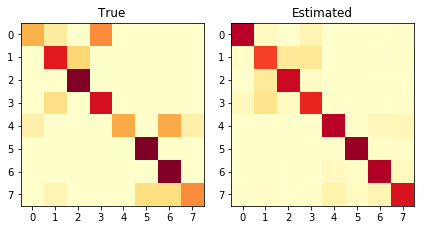

JS divergence: 0.1224	Norm Frobenius: 0.1300


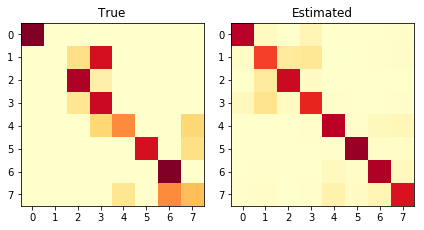

JS divergence: 0.1770	Norm Frobenius: 0.1613


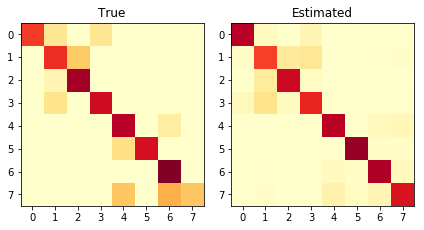

JS divergence: 0.0879	Norm Frobenius: 0.0974


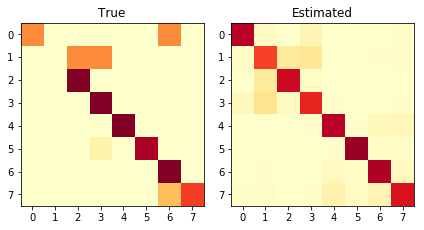

JS divergence: 0.1755	Norm Frobenius: 0.1467


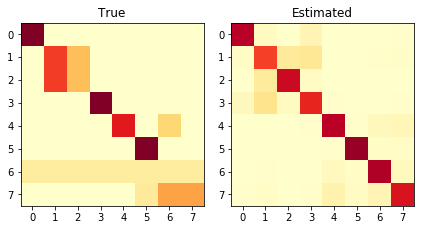

JS divergence: 0.1830	Norm Frobenius: 0.1652


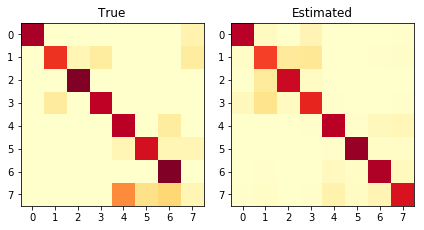

JS divergence: 0.1154	Norm Frobenius: 0.1195


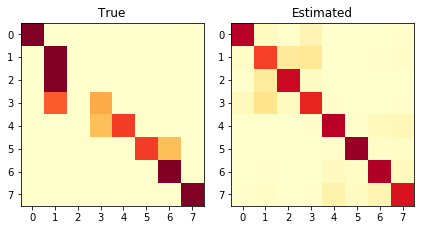

JS divergence: 0.2061	Norm Frobenius: 0.1893


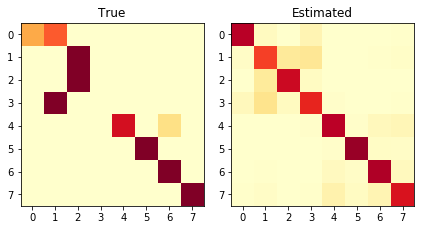

JS divergence: 0.2528	Norm Frobenius: 0.2205


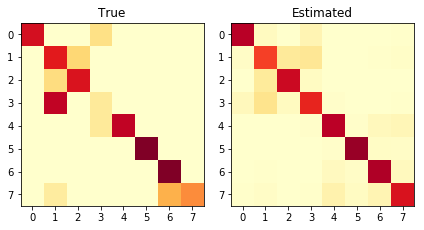

JS divergence: 0.1182	Norm Frobenius: 0.1318


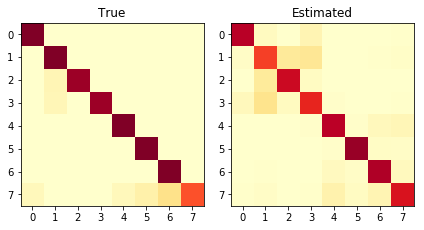

JS divergence: 0.0730	Norm Frobenius: 0.0744


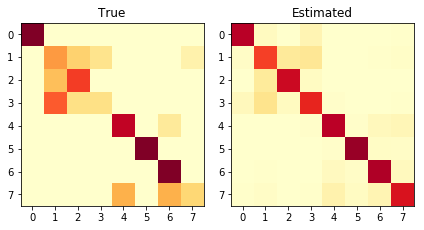

JS divergence: 0.1103	Norm Frobenius: 0.1325


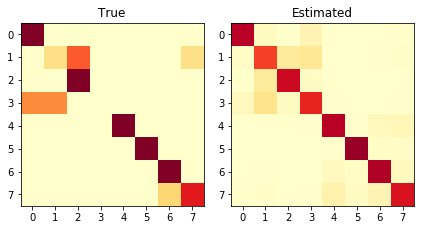

JS divergence: 0.1729	Norm Frobenius: 0.1515


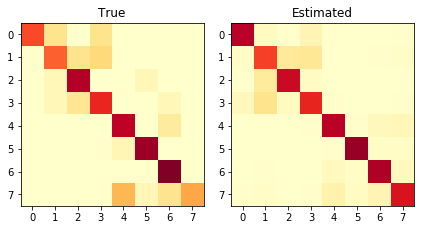

JS divergence: 0.0695	Norm Frobenius: 0.0800


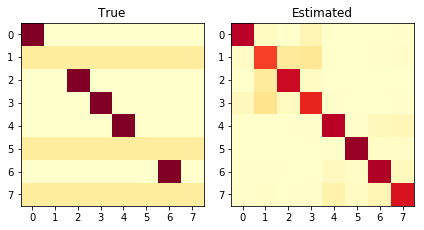

JS divergence: 0.2282	Norm Frobenius: 0.1701


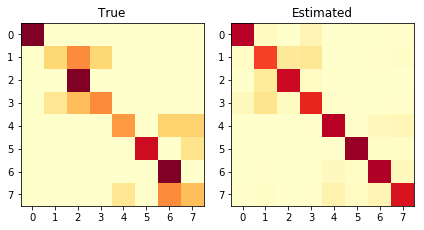

JS divergence: 0.1273	Norm Frobenius: 0.1396
Calculate confusion matrix on global version


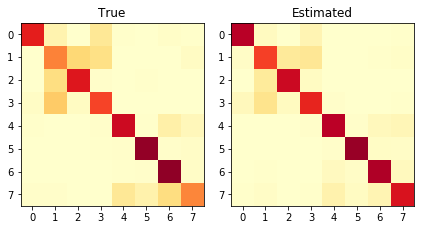

JS divergence: 0.0242	Norm Frobenius: 0.0566
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.826       0.826        0.172003     0.216288     0.121733   

   (R) JS w  (G) NormF    (G) JS  
0  0.122006   0.056558  0.024225

Test
A result


Accuracy  F1 (micro)
0  All  0.794613    0.794613

In [18]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


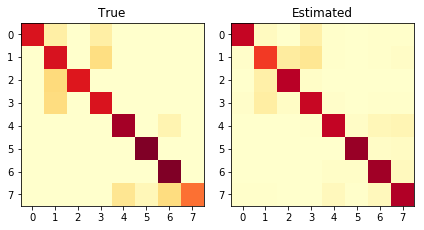

JS divergence: 0.0510	Norm Frobenius: 0.0650


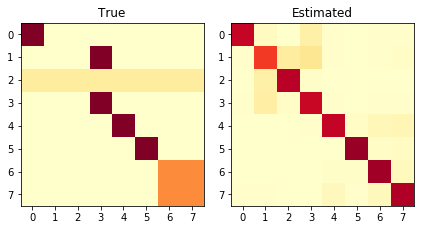

JS divergence: 0.2464	Norm Frobenius: 0.2055


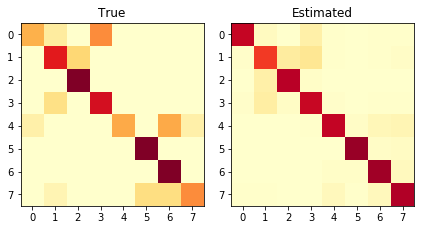

JS divergence: 0.1153	Norm Frobenius: 0.1279


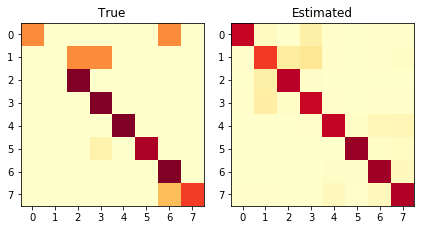

JS divergence: 0.1641	Norm Frobenius: 0.1445


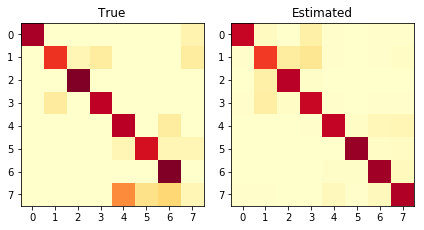

JS divergence: 0.1245	Norm Frobenius: 0.1305


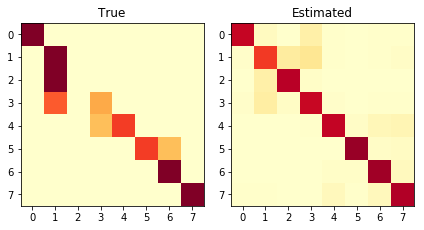

JS divergence: 0.2129	Norm Frobenius: 0.1991


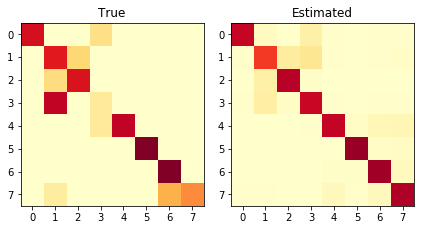

JS divergence: 0.1306	Norm Frobenius: 0.1499


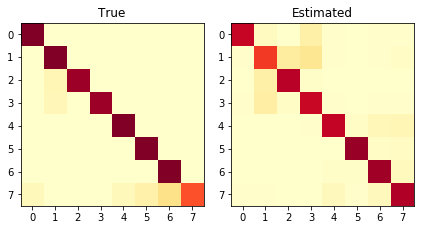

JS divergence: 0.0697	Norm Frobenius: 0.0743


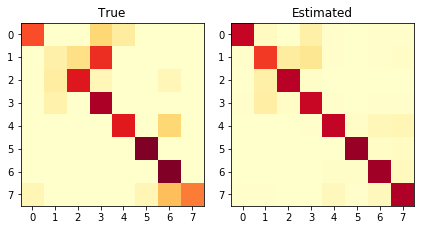

JS divergence: 0.1062	Norm Frobenius: 0.1262


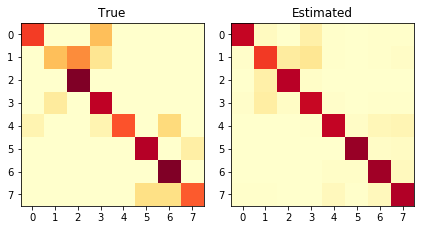

JS divergence: 0.0894	Norm Frobenius: 0.1000


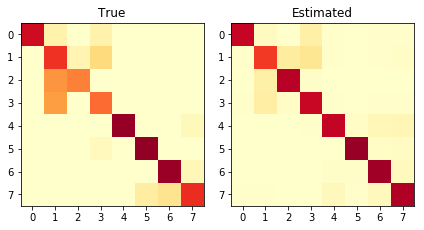

JS divergence: 0.0635	Norm Frobenius: 0.0917


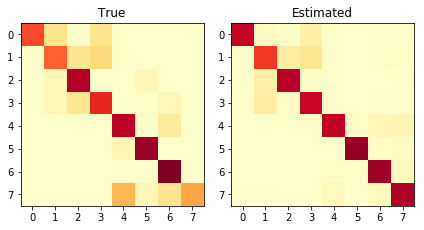

JS divergence: 0.0726	Norm Frobenius: 0.0888


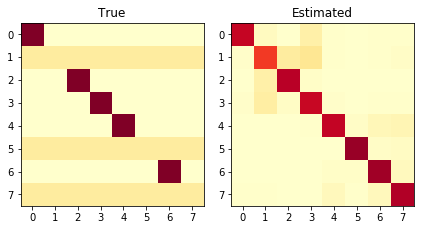

JS divergence: 0.2350	Norm Frobenius: 0.1752


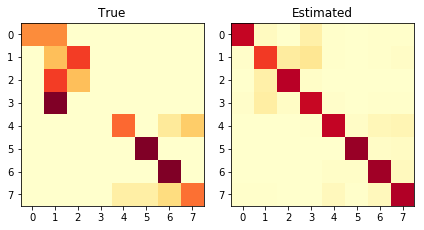

JS divergence: 0.2305	Norm Frobenius: 0.2232


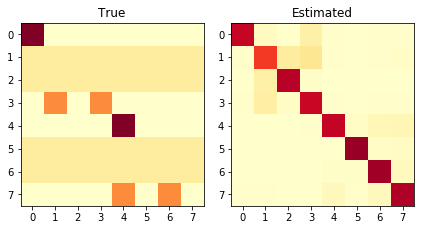

JS divergence: 0.4050	Norm Frobenius: 0.2530
Calculate confusion matrix on global version


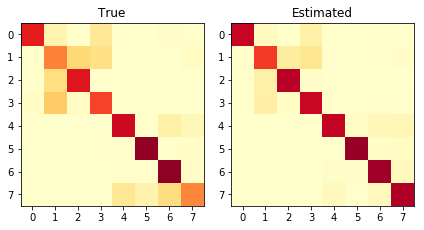

JS divergence: 0.0347	Norm Frobenius: 0.0736
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.804       0.804        0.181207     0.225159     0.130604   

   (R) JS w  (G) NormF    (G) JS  
0   0.12677   0.073609  0.034694

Test
A result


Accuracy  F1 (micro)
0  All   0.79798     0.79798

In [20]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


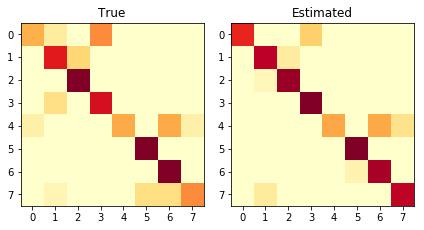

JS divergence: 0.0799	Norm Frobenius: 0.0938


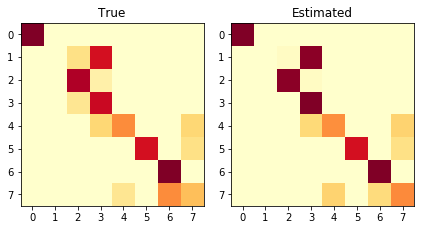

JS divergence: 0.0285	Norm Frobenius: 0.0615


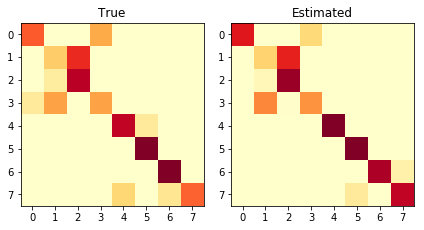

JS divergence: 0.0667	Norm Frobenius: 0.0725


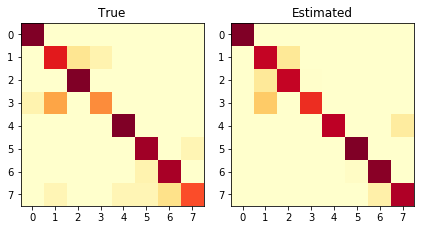

JS divergence: 0.0518	Norm Frobenius: 0.0645


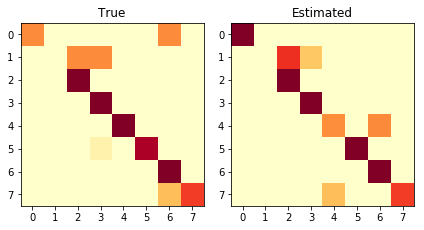

JS divergence: 0.1301	Norm Frobenius: 0.1441


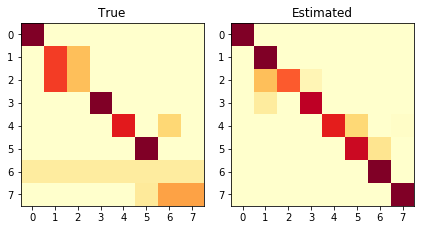

JS divergence: 0.2246	Norm Frobenius: 0.1782


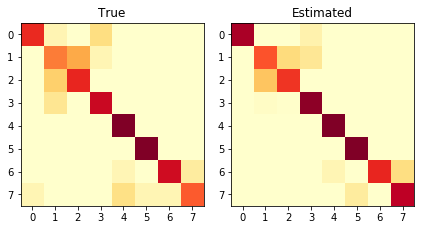

JS divergence: 0.0438	Norm Frobenius: 0.0671


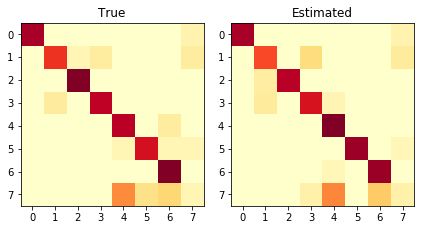

JS divergence: 0.0568	Norm Frobenius: 0.0516


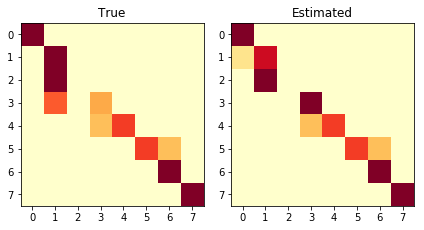

JS divergence: 0.0618	Norm Frobenius: 0.1109


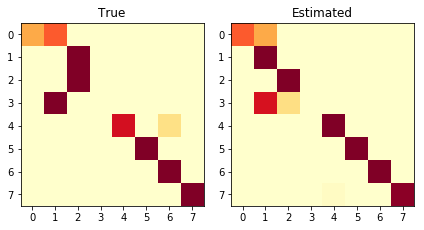

JS divergence: 0.1578	Norm Frobenius: 0.1873


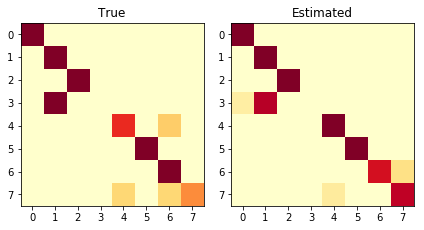

JS divergence: 0.0627	Norm Frobenius: 0.0865


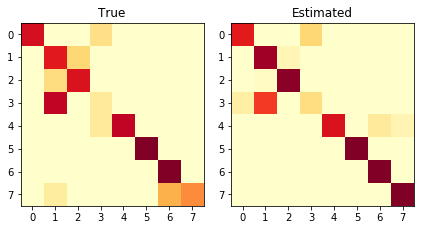

JS divergence: 0.0858	Norm Frobenius: 0.1016


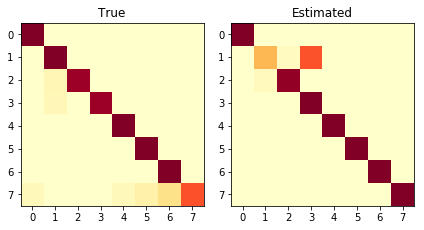

JS divergence: 0.0871	Norm Frobenius: 0.1252


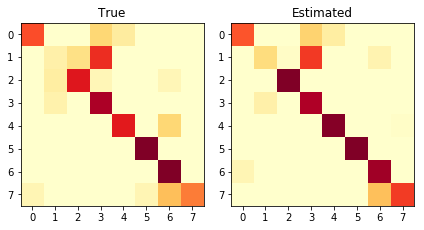

JS divergence: 0.0628	Norm Frobenius: 0.0672


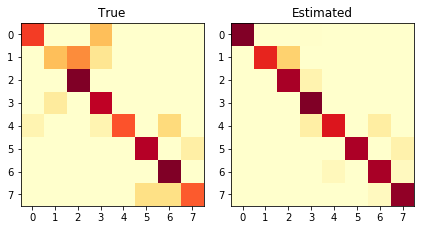

JS divergence: 0.0912	Norm Frobenius: 0.1086
Calculate confusion matrix on global version


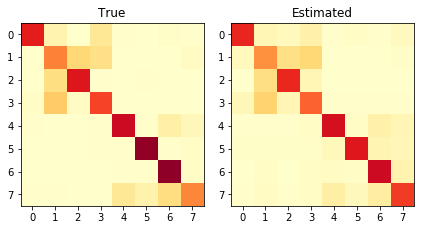

JS divergence: 0.0357	Norm Frobenius: 0.0468
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.864       0.864        0.139434      0.15302     0.098342   

   (R) JS w  (G) NormF   (G) JS  
0  0.085778   0.046829  0.03573

Test
A result


Accuracy  F1 (micro)
0  All  0.835859    0.835859

In [22]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


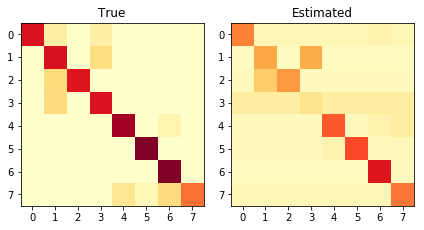

JS divergence: 0.2167	Norm Frobenius: 0.1388


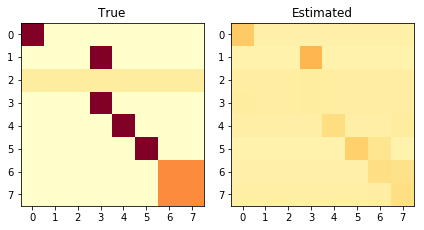

JS divergence: 0.4517	Norm Frobenius: 0.2420


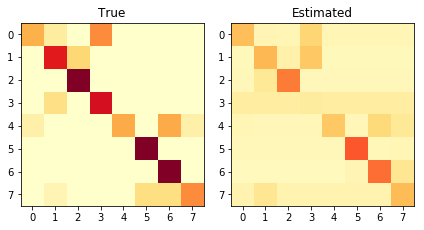

JS divergence: 0.2862	Norm Frobenius: 0.1646


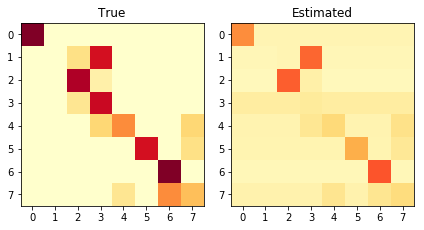

JS divergence: 0.2891	Norm Frobenius: 0.1635


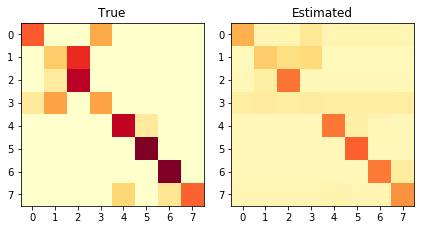

JS divergence: 0.2775	Norm Frobenius: 0.1520


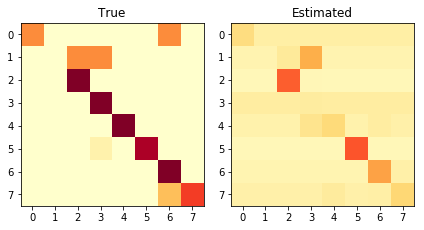

JS divergence: 0.4123	Norm Frobenius: 0.2159


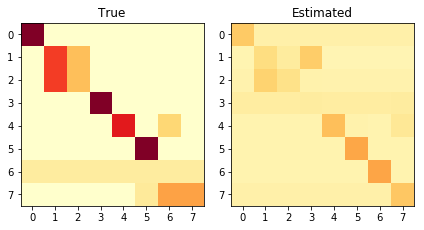

JS divergence: 0.3981	Norm Frobenius: 0.2144


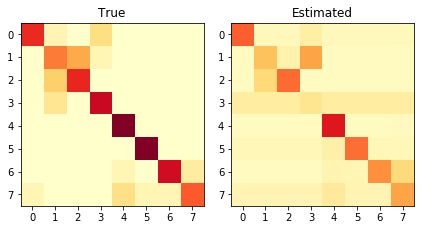

JS divergence: 0.2142	Norm Frobenius: 0.1443


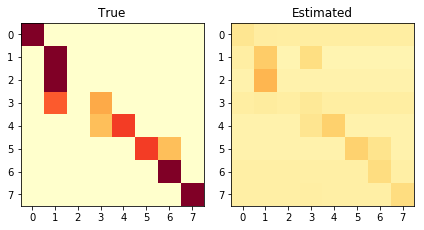

JS divergence: 0.4964	Norm Frobenius: 0.2515


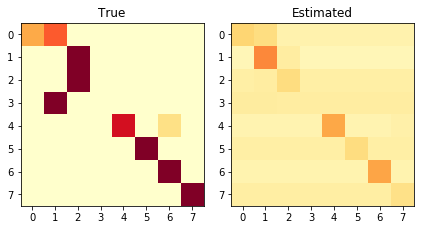

JS divergence: 0.5326	Norm Frobenius: 0.2757


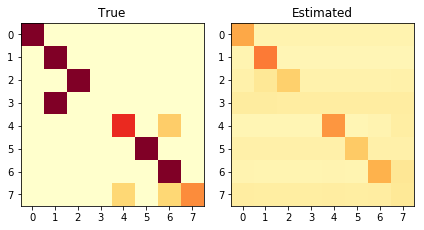

JS divergence: 0.4382	Norm Frobenius: 0.2335


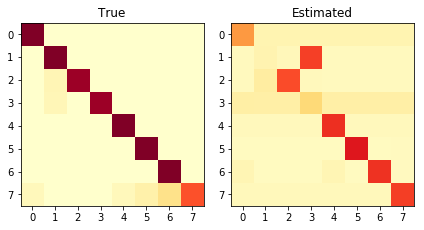

JS divergence: 0.2959	Norm Frobenius: 0.2018


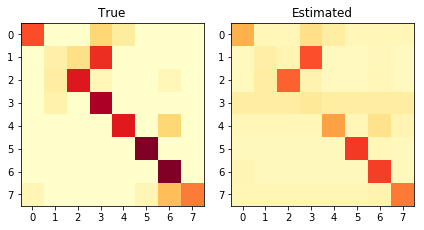

JS divergence: 0.2205	Norm Frobenius: 0.1416


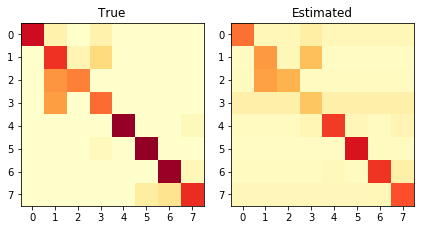

JS divergence: 0.1647	Norm Frobenius: 0.1021


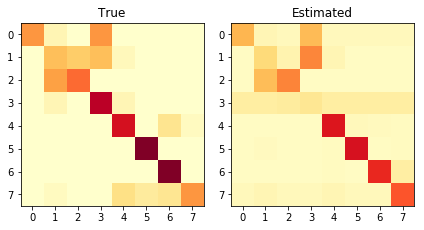

JS divergence: 0.1693	Norm Frobenius: 0.1229
Calculate confusion matrix on global version


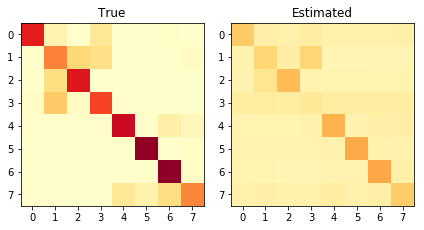

JS divergence: 0.2774	Norm Frobenius: 0.1762
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.746       0.746        0.189759     0.319859     0.164402   

   (R) JS w  (G) NormF   (G) JS  RMSE mean    RMSE w  
0  0.274857   0.176225  0.27739     0.0681  0.050255

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                 0.80951             1.16896                 0.783274   

   Cross entropy wmean  
0              0.95573

Test
A result


Accuracy  F1 (micro)
0  All  0.736532    0.736532

In [25]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


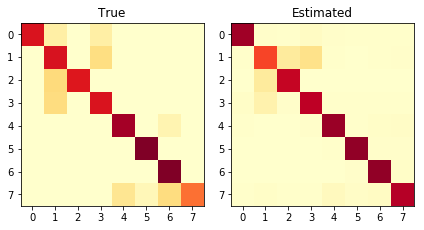

JS divergence: 0.0566	Norm Frobenius: 0.0679
Groups probabilities:  [1. 0. 0.]


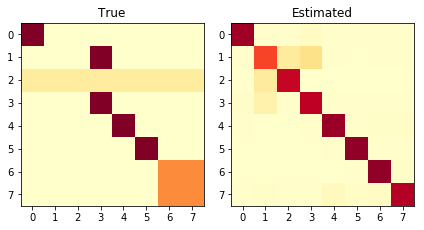

JS divergence: 0.2320	Norm Frobenius: 0.2000
Groups probabilities:  [1. 0. 0.]


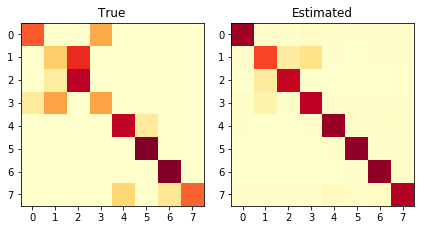

JS divergence: 0.1248	Norm Frobenius: 0.1409
Groups probabilities:  [1. 0. 0.]


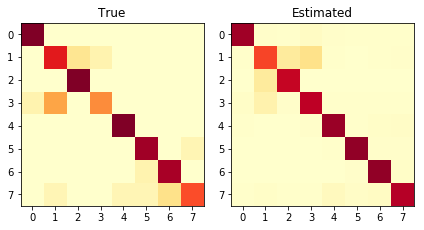

JS divergence: 0.0625	Norm Frobenius: 0.0827
Groups probabilities:  [1. 0. 0.]


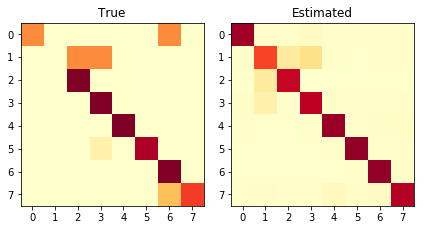

JS divergence: 0.1501	Norm Frobenius: 0.1430
Groups probabilities:  [1. 0. 0.]


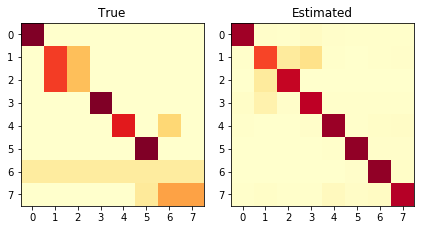

JS divergence: 0.1902	Norm Frobenius: 0.1739
Groups probabilities:  [1. 0. 0.]


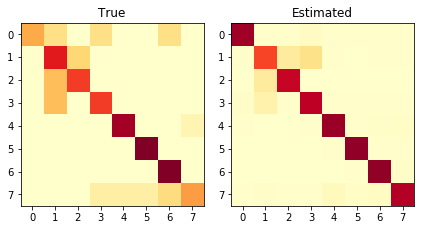

JS divergence: 0.1062	Norm Frobenius: 0.1177
Groups probabilities:  [1. 0. 0.]


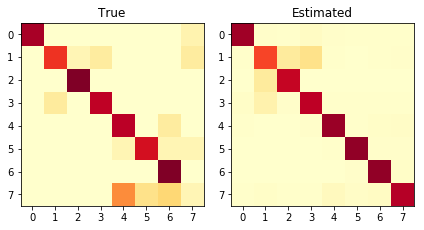

JS divergence: 0.1259	Norm Frobenius: 0.1313
Groups probabilities:  [1. 0. 0.]


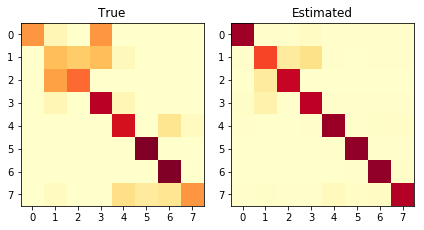

JS divergence: 0.0985	Norm Frobenius: 0.1260
Groups probabilities:  [1. 0. 0.]


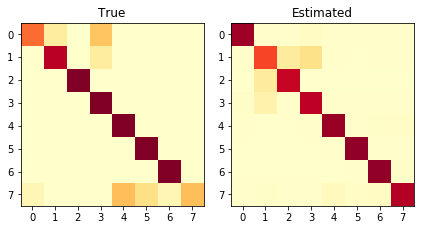

JS divergence: 0.1010	Norm Frobenius: 0.1127
Groups probabilities:  [1. 0. 0.]


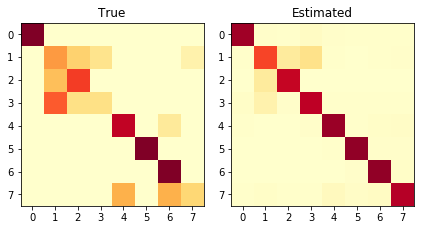

JS divergence: 0.1338	Norm Frobenius: 0.1559
Groups probabilities:  [1. 0. 0.]


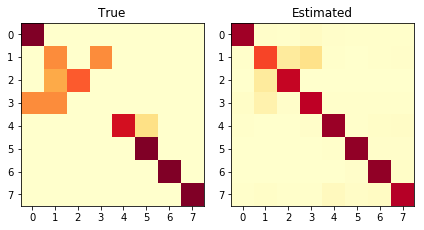

JS divergence: 0.1548	Norm Frobenius: 0.1537
Groups probabilities:  [1. 0. 0.]


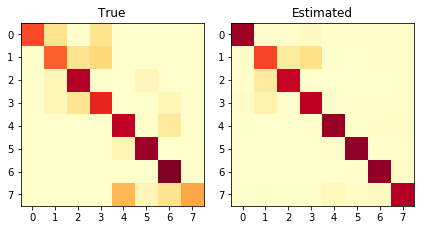

JS divergence: 0.0836	Norm Frobenius: 0.0956
Groups probabilities:  [1. 0. 0.]


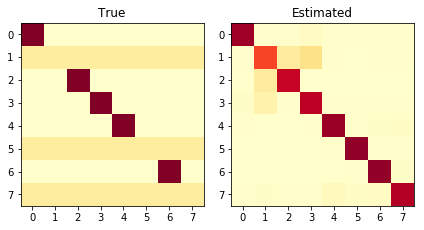

JS divergence: 0.2172	Norm Frobenius: 0.1722
Groups probabilities:  [1. 0. 0.]


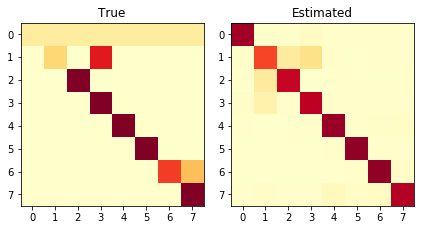

JS divergence: 0.1555	Norm Frobenius: 0.1535
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


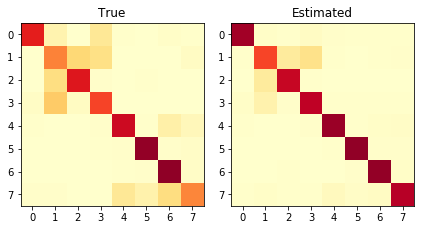

JS divergence: 0.0473	Norm Frobenius: 0.0795
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.853       0.853           0.185       0.2281       0.1343   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0    0.1317     0.0795  0.0473     0.1734  0.1296

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.7515              0.6746                   0.7888   

   Cross entropy wmean  
0                0.617

Test


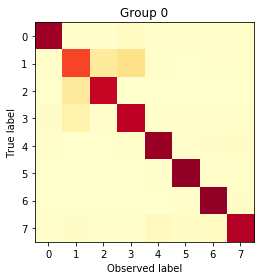

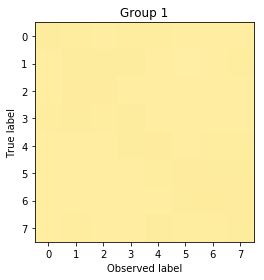

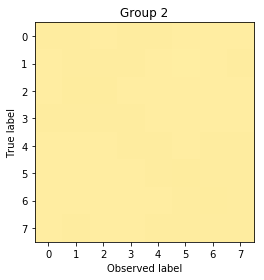

Inertia JS: 0.3501555499831124
Inertia NormF: 0.1925510933312277
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.9972    58   0.4696     0.8809     0.9069    0.8639  0.0125   
1       1  0.0018     0   2.0785     0.1330    -0.0162    0.0091  0.0017   
2       2  0.0010     0   2.0793     0.1284    -0.0265    0.0039  0.0008   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       3   0.3502      0.1926    0.8359      0.8359  
1       7   0.3502      0.1926    0.6254      0.6254  
2       7   0.3502      0.1926    0.6136      0.6136

A result


Accuracy  F1 (micro)
0  All    0.8266      0.8266

In [20]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


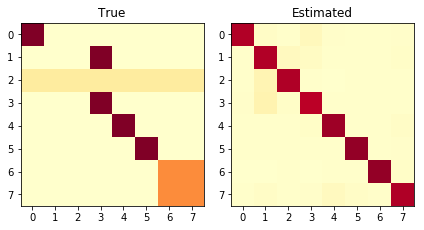

JS divergence: 0.2762	Norm Frobenius: 0.2281
Groups probabilities:  [0.9428 0.0572]


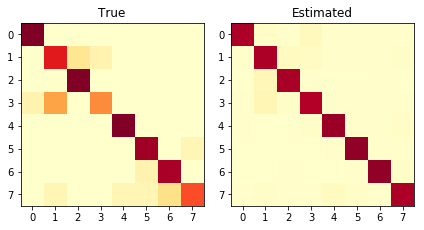

JS divergence: 0.0716	Norm Frobenius: 0.0869
Groups probabilities:  [9.993e-01 7.000e-04]


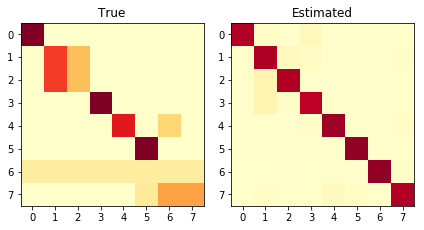

JS divergence: 0.2069	Norm Frobenius: 0.1832
Groups probabilities:  [0.9365 0.0635]


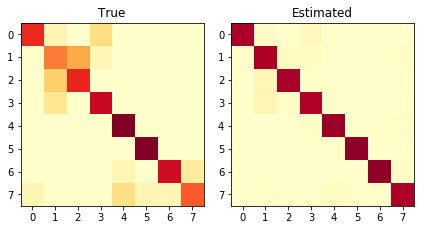

JS divergence: 0.0821	Norm Frobenius: 0.0988
Groups probabilities:  [9.996e-01 4.000e-04]


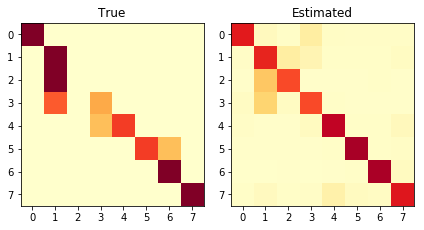

JS divergence: 0.1767	Norm Frobenius: 0.1582
Groups probabilities:  [0.1331 0.8669]


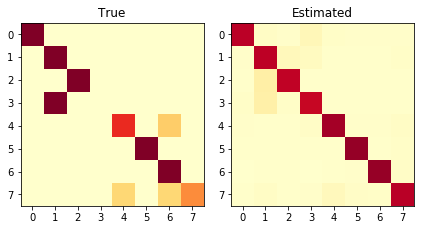

JS divergence: 0.1731	Norm Frobenius: 0.1747
Groups probabilities:  [0.83 0.17]


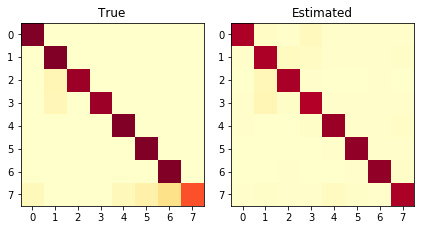

JS divergence: 0.0425	Norm Frobenius: 0.0495
Groups probabilities:  [1. 0.]


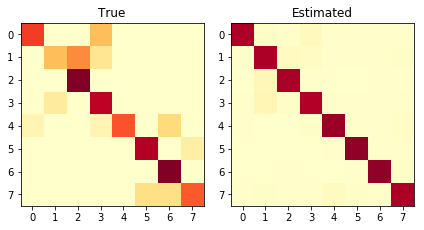

JS divergence: 0.1245	Norm Frobenius: 0.1299
Groups probabilities:  [1. 0.]


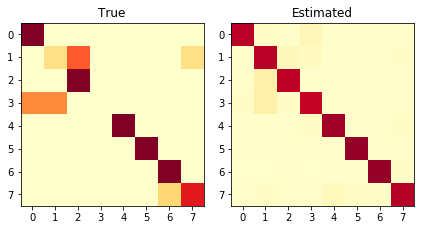

JS divergence: 0.1993	Norm Frobenius: 0.1795
Groups probabilities:  [0.8648 0.1352]


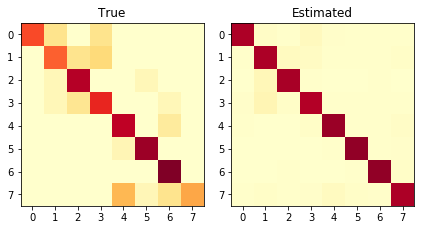

JS divergence: 0.1017	Norm Frobenius: 0.1086
Groups probabilities:  [1. 0.]


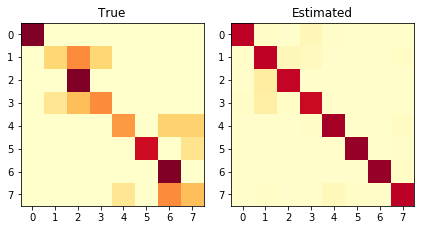

JS divergence: 0.1810	Norm Frobenius: 0.1694
Groups probabilities:  [0.7899 0.2101]


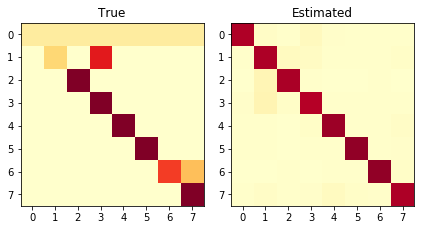

JS divergence: 0.1709	Norm Frobenius: 0.1715
Groups probabilities:  [0.9815 0.0185]


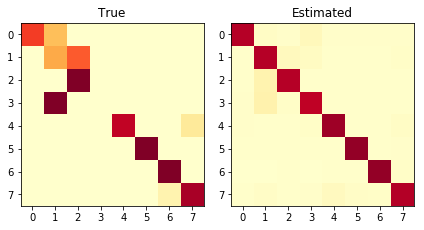

JS divergence: 0.1880	Norm Frobenius: 0.1913
Groups probabilities:  [0.9136 0.0864]


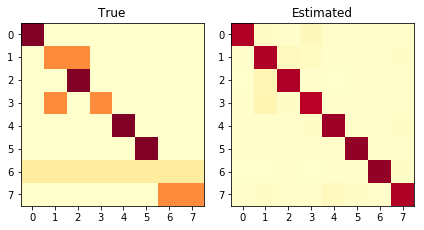

JS divergence: 0.1868	Norm Frobenius: 0.1737
Groups probabilities:  [0.9569 0.0431]


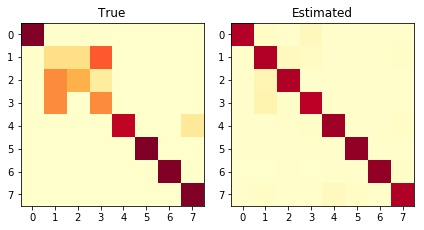

JS divergence: 0.1408	Norm Frobenius: 0.1618
Groups probabilities:  [0.9401 0.0599]
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.843       0.843           0.188       0.2326       0.1421   

   (R) JS w  RMSE mean  RMSE w  
0    0.1441     0.1456  0.1052

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.7979              0.5589                   0.8214   

   Cross entropy wmean  
0               0.5187

Test


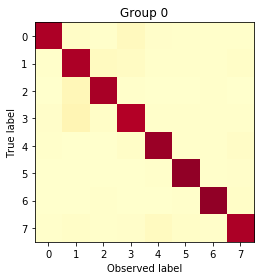

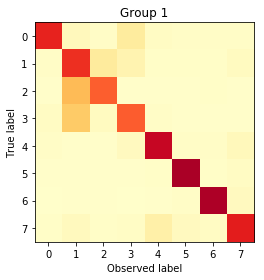

Inertia JS: 0.046423794238964984
Inertia NormF: 0.08692646026611328
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.6998    41   0.3795     0.9251     0.9443    0.9144  0.0096   
1       1  0.3002    17   0.8516     0.7517     0.7971    0.7162  0.0601   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.0464      0.0869    0.8325      0.8325  
1       1   0.0464      0.0869    0.8199      0.8199

A result


Accuracy  F1 (micro)
0  All    0.8333      0.8333

In [27]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual1 multiples runs***
Train
Calculate confusion matrix on repeat version


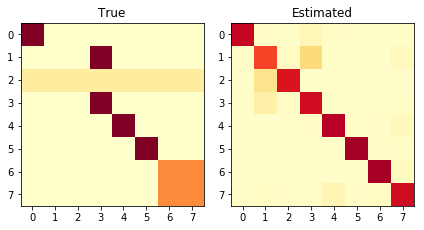

JS divergence: 0.2313	Norm Frobenius: 0.1915
Groups probabilities:  [0.1609 0.755  0.0841]


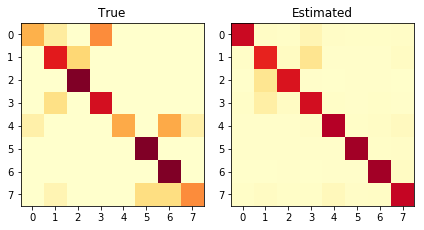

JS divergence: 0.1519	Norm Frobenius: 0.1359
Groups probabilities:  [0.3804 0.3308 0.2887]


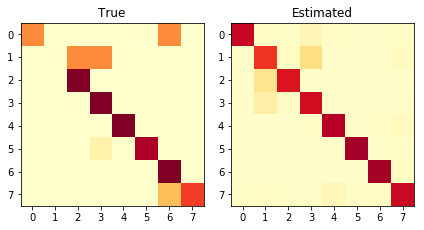

JS divergence: 0.1880	Norm Frobenius: 0.1490
Groups probabilities:  [0.2518 0.5736 0.1746]


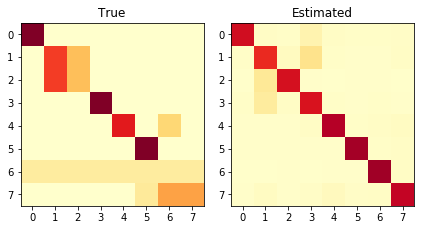

JS divergence: 0.2123	Norm Frobenius: 0.1725
Groups probabilities:  [0.7133 0.1697 0.117 ]


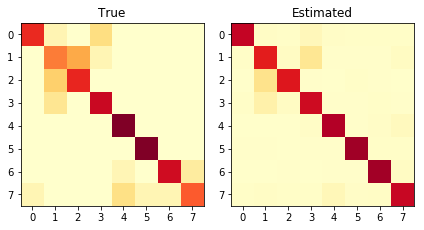

JS divergence: 0.0798	Norm Frobenius: 0.0784
Groups probabilities:  [0.1002 0.461  0.4387]


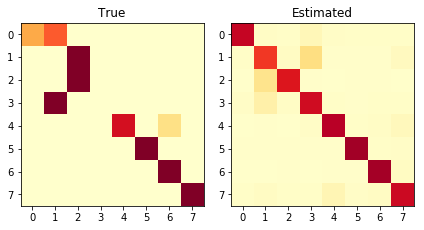

JS divergence: 0.3058	Norm Frobenius: 0.2389
Groups probabilities:  [0.1178 0.6811 0.2011]


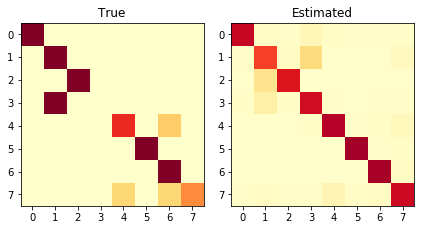

JS divergence: 0.1966	Norm Frobenius: 0.1793
Groups probabilities:  [0.1426 0.7379 0.1195]


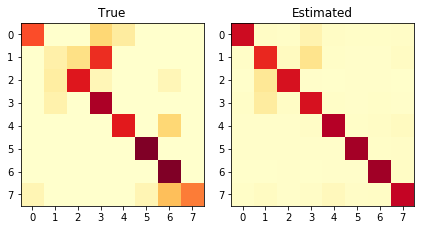

JS divergence: 0.1278	Norm Frobenius: 0.1295
Groups probabilities:  [0.6069 0.2216 0.1715]


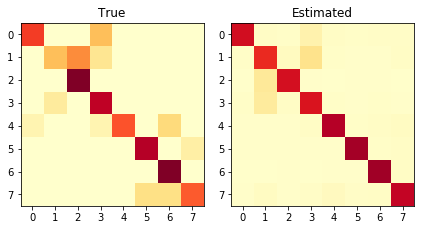

JS divergence: 0.1205	Norm Frobenius: 0.1110
Groups probabilities:  [0.7759 0.1341 0.09  ]


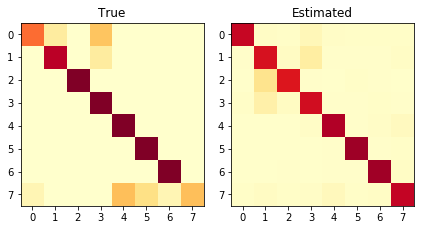

JS divergence: 0.1054	Norm Frobenius: 0.1056
Groups probabilities:  [0.2542 0.1813 0.5645]


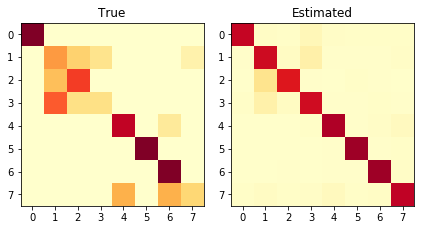

JS divergence: 0.1556	Norm Frobenius: 0.1566
Groups probabilities:  [0.233  0.1034 0.6636]


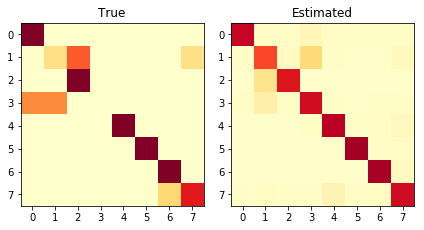

JS divergence: 0.2203	Norm Frobenius: 0.1713
Groups probabilities:  [0.1177 0.8106 0.0716]


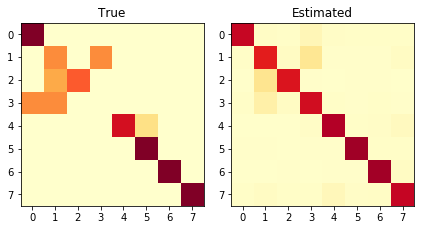

JS divergence: 0.1640	Norm Frobenius: 0.1493
Groups probabilities:  [0.2493 0.3605 0.3902]


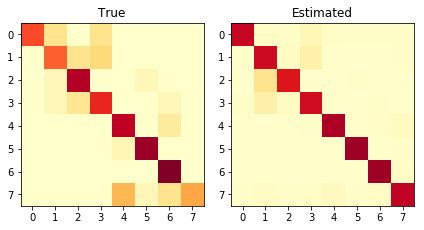

JS divergence: 0.0977	Norm Frobenius: 0.0966
Groups probabilities:  [0.2734 0.061  0.6656]


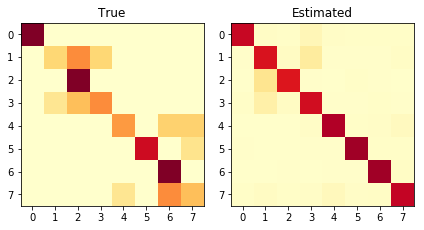

JS divergence: 0.1804	Norm Frobenius: 0.1635
Groups probabilities:  [0.2852 0.1968 0.518 ]
Calculate confusion matrix on global version


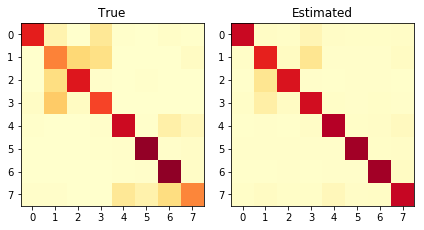

JS divergence: 0.0533	Norm Frobenius: 0.0744
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All     0.848       0.848      0.8458          0.1799       0.2311   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0       0.1298    0.1438     0.0744  0.0533     0.1421  0.1048

A result


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ACC imiting Annot mean  F1-mi imiting Annot mean  F1-ma imiting Annot mean  \
0                   0.797                     0.797                    0.7431   

   ACC imiting Annot wmean  F1-mi imiting Annot wmean  \
0                    0.817                      0.817   

   F1-ma imiting Annot wmean  
0                     0.7828

Test


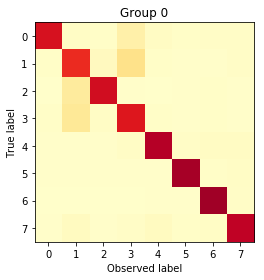

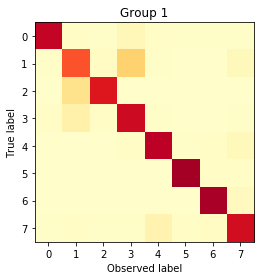

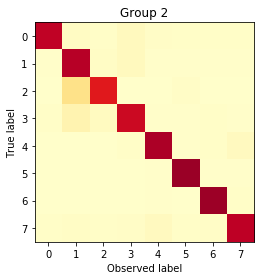

Inertia JS: 0.009999621226135041
Inertia NormF: 0.03534468247290514
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.3194    18   0.6709     0.8352     0.9110    0.8116  0.0143   
1       1  0.3620    21   0.6878     0.8219     0.9024    0.7964  0.0253   
2       2  0.3186    18   0.5618     0.8736     0.9330    0.8556  0.0294   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       3     0.01      0.0353    0.8300      0.8300  
1       3     0.01      0.0353    0.8316      0.8316  
2       1     0.01      0.0353    0.8333      0.8333

A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.8316      0.8316      0.8289

In [45]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual1 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual3 multiples runs***
Train
Calculate confusion matrix on repeat version


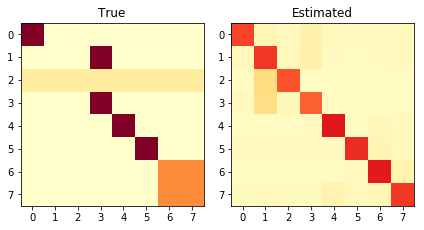

JS divergence: 0.2892	Norm Frobenius: 0.2023
Groups probabilities:  [0.2321 0.5164 0.2516]


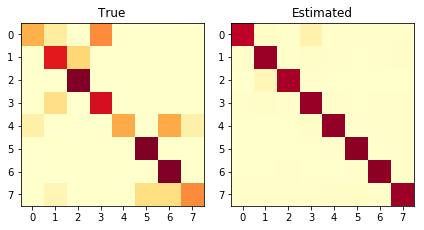

JS divergence: 0.1419	Norm Frobenius: 0.1451
Groups probabilities:  [0.000e+00 9.999e-01 1.000e-04]


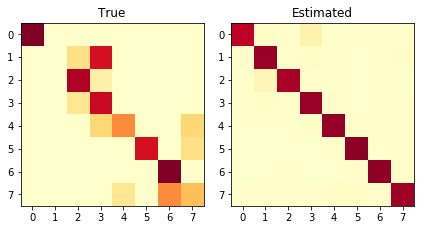

JS divergence: 0.2412	Norm Frobenius: 0.2029
Groups probabilities:  [0.0014 0.997  0.0016]


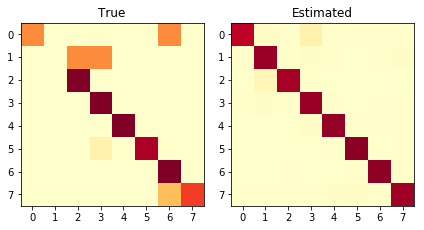

JS divergence: 0.2008	Norm Frobenius: 0.1751
Groups probabilities:  [7.000e-04 9.988e-01 4.000e-04]


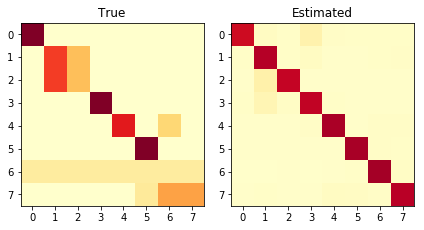

JS divergence: 0.2069	Norm Frobenius: 0.1779
Groups probabilities:  [0.0367 0.8863 0.0771]


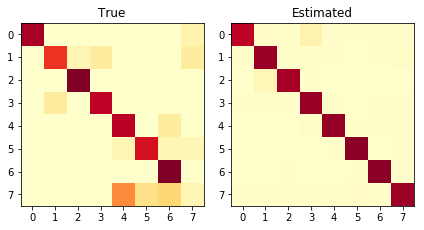

JS divergence: 0.1494	Norm Frobenius: 0.1422
Groups probabilities:  [0. 1. 0.]


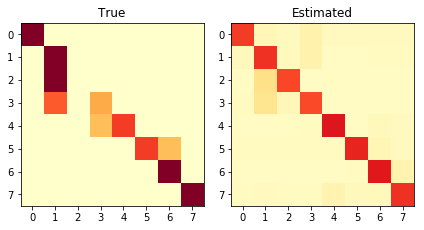

JS divergence: 0.2334	Norm Frobenius: 0.1730
Groups probabilities:  [0.2462 0.5727 0.1811]


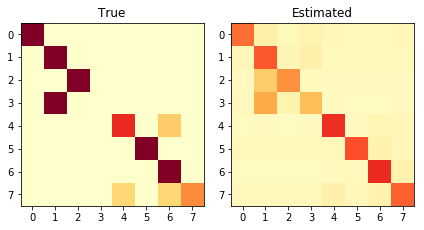

JS divergence: 0.2434	Norm Frobenius: 0.1600
Groups probabilities:  [0.1719 0.2547 0.5734]


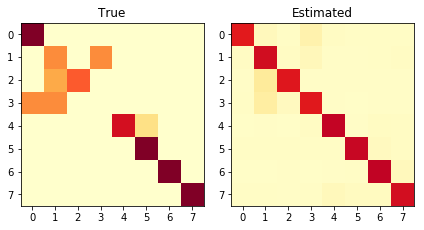

JS divergence: 0.1992	Norm Frobenius: 0.1559
Groups probabilities:  [0.1134 0.751  0.1356]


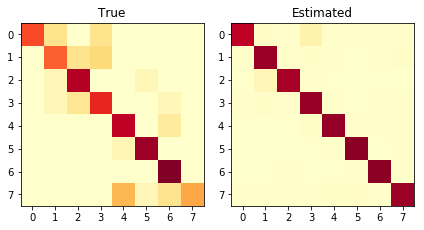

JS divergence: 0.1086	Norm Frobenius: 0.1137
Groups probabilities:  [0. 1. 0.]


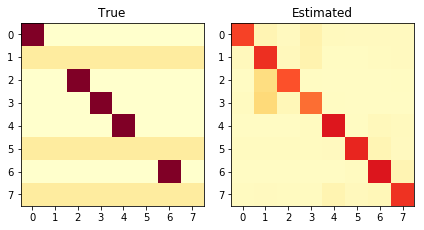

JS divergence: 0.2206	Norm Frobenius: 0.1705
Groups probabilities:  [0.1792 0.5089 0.3119]


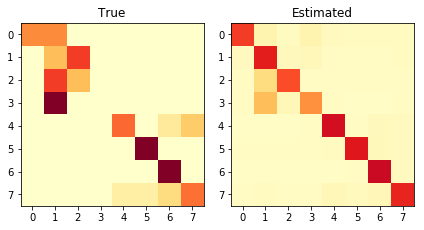

JS divergence: 0.2284	Norm Frobenius: 0.1793
Groups probabilities:  [0.0193 0.4754 0.5053]


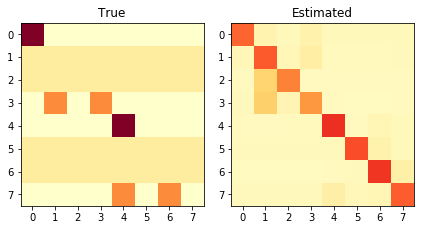

JS divergence: 0.2661	Norm Frobenius: 0.1858
Groups probabilities:  [0.2948 0.3626 0.3425]


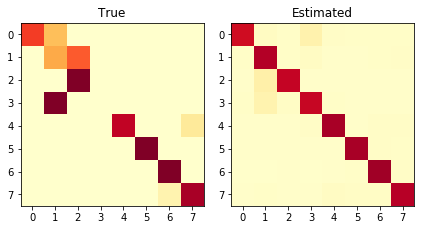

JS divergence: 0.2056	Norm Frobenius: 0.1909
Groups probabilities:  [0.0165 0.8762 0.1073]


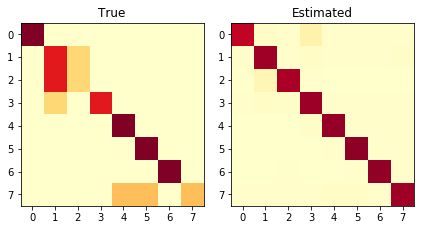

JS divergence: 0.1456	Norm Frobenius: 0.1621
Groups probabilities:  [0.0062 0.9883 0.0054]
Calculate confusion matrix on global version


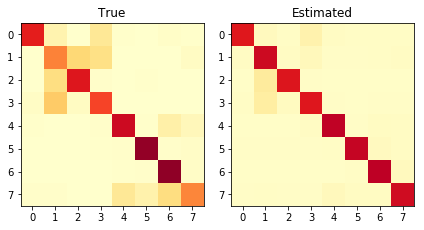

JS divergence: 0.0681	Norm Frobenius: 0.0788
A result


Accuracy  F1 (micro)  F1 (macro)  (R) NormF mean  (R) JS mean  \
0  All     0.816       0.816      0.8127          0.1767       0.2154   

   (R) NormF w  (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0       0.1455    0.1529     0.0788  0.0681     0.1136  0.0746

A result


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ACC imiting Annot mean  F1-mi imiting Annot mean  F1-ma imiting Annot mean  \
0                  0.8148                    0.8148                    0.7588   

   ACC imiting Annot wmean  F1-mi imiting Annot wmean  \
0                   0.8465                     0.8465   

   F1-ma imiting Annot wmean  
0                     0.8122

Test


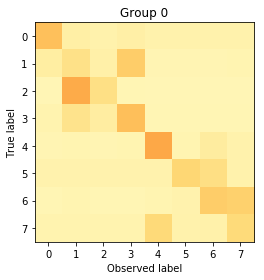

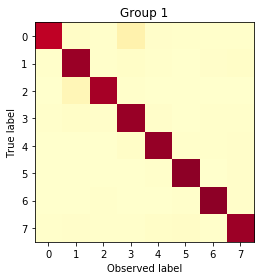

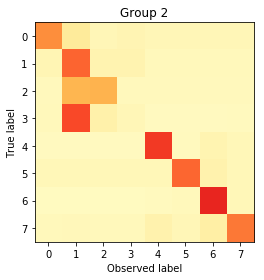

Inertia JS: 0.23718783894150255
Inertia NormF: 0.1941503920649754
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.0952     5   1.8903     0.2817     0.4825    0.1791  0.0258   
1       1  0.7619    44   0.3158     0.9386     0.9684    0.9298  0.0088   
2       2  0.1429     8   1.4346     0.5023     0.6633    0.4312  0.1234   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.2372      0.1942    0.6448      0.6448  
1       3   0.2372      0.1942    0.8418      0.8418  
2       1   0.2372      0.1942    0.6944      0.6944

A result


Accuracy  F1 (micro)  F1 (macro)
0  All    0.8401      0.8401      0.8375

In [29]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

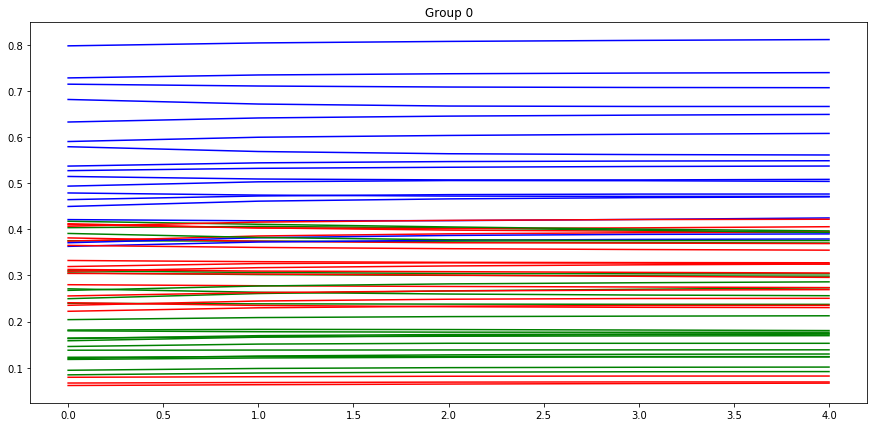

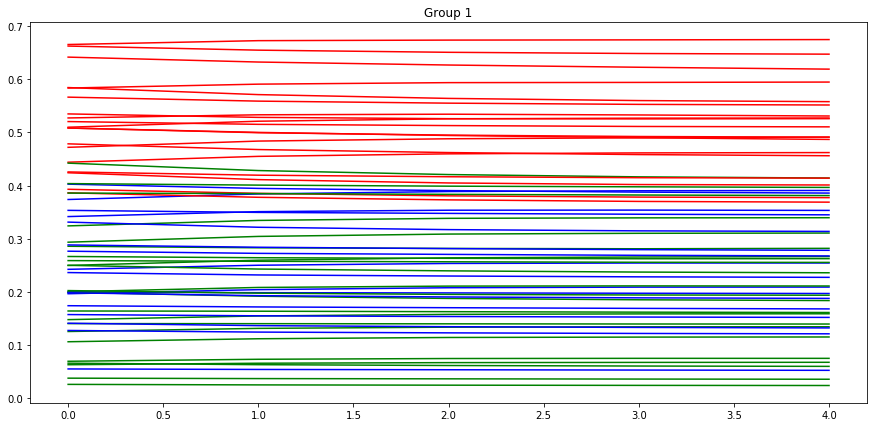

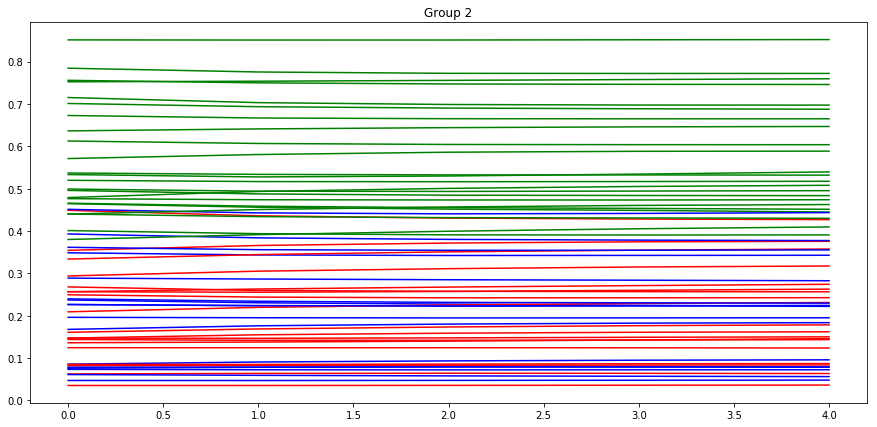

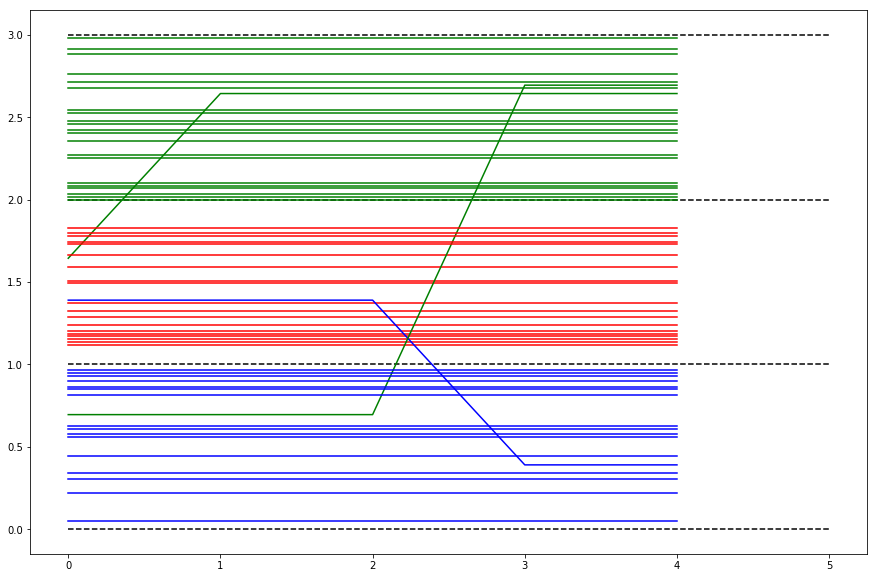

In [38]:
plot_alphas(gMixture_Ind1.alphas_training)

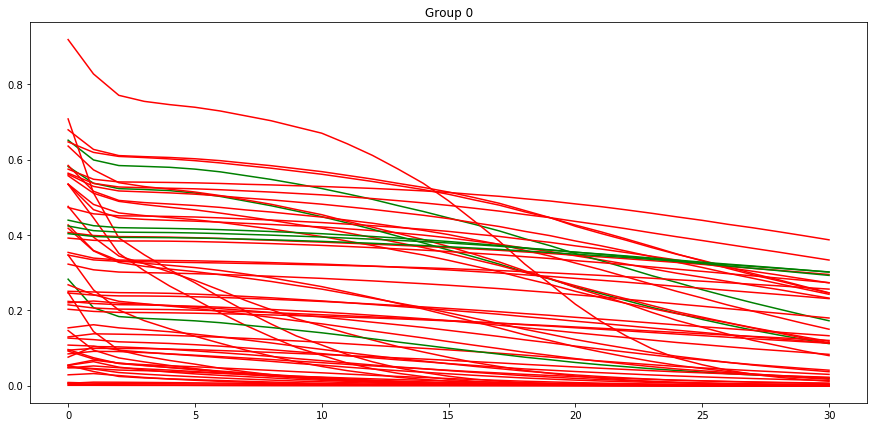

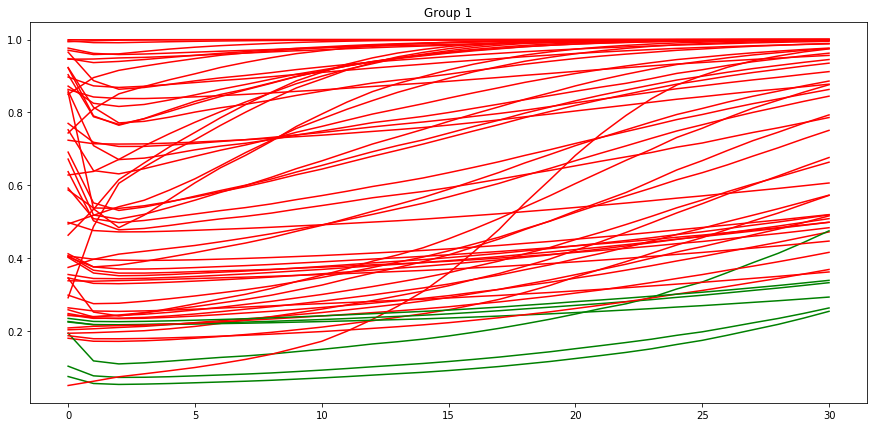

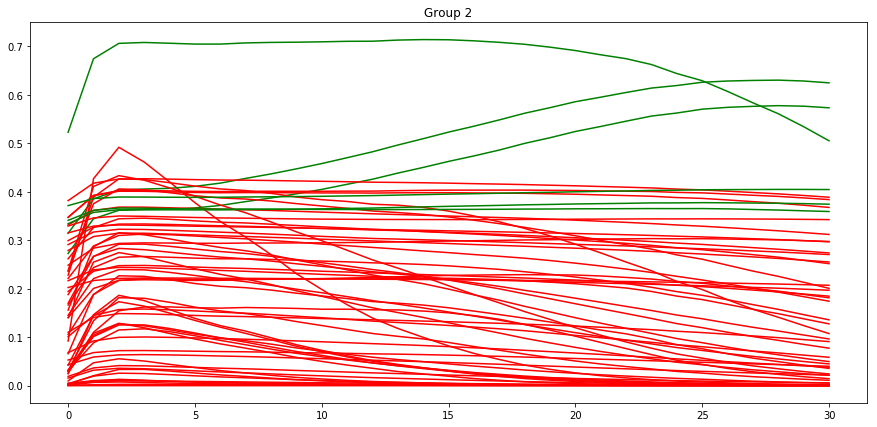

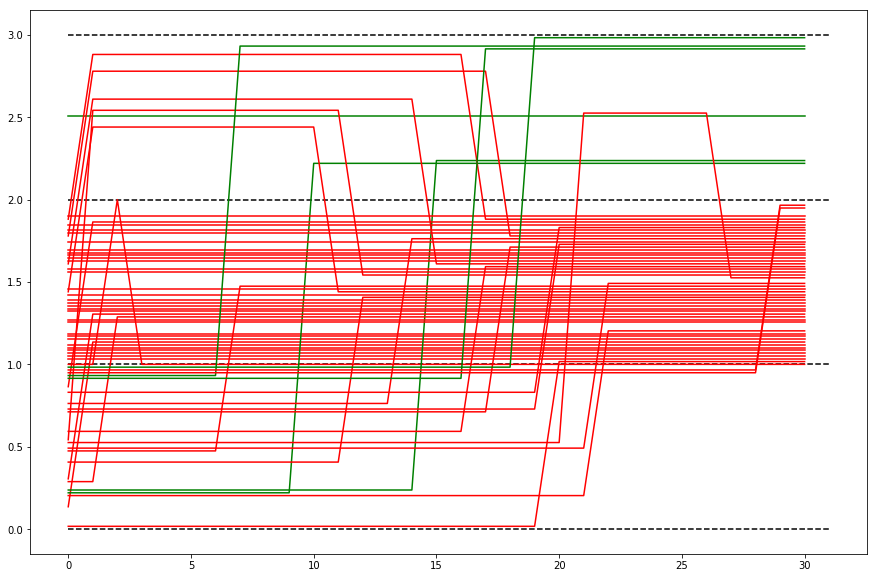

In [39]:
plot_alphas(gMixture_Ind3.alphas_training)

### project confusion matrices

In [66]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

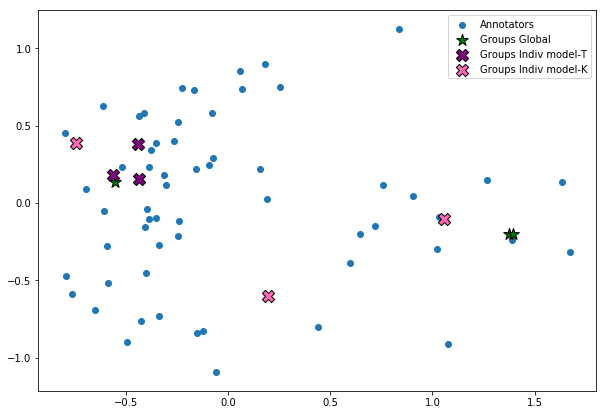

In [67]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo

In [ ]:
### e individual con 2 grupos??

*** Ours Individual2 multiples runs***
Train
Calculate confusion matrix on repeat version


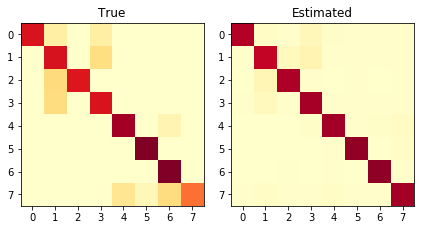

JS divergence: 0.0658	Norm Frobenius: 0.0752
Groups probabilities:  [0. 1.]


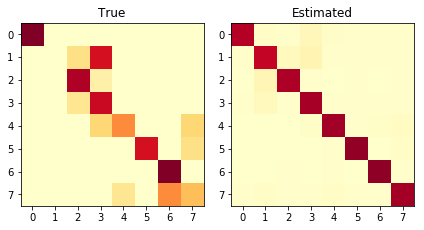

JS divergence: 0.2128	Norm Frobenius: 0.1897
Groups probabilities:  [0. 1.]


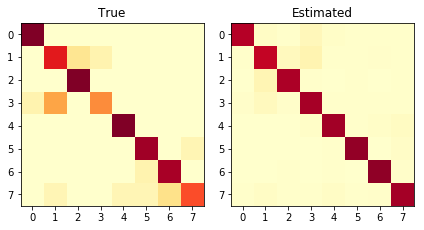

JS divergence: 0.0768	Norm Frobenius: 0.0907
Groups probabilities:  [0. 1.]


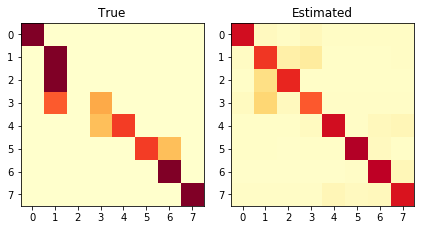

JS divergence: 0.1936	Norm Frobenius: 0.1687
Groups probabilities:  [1. 0.]


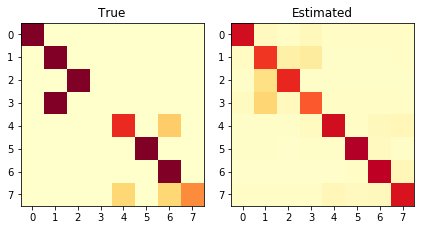

JS divergence: 0.1789	Norm Frobenius: 0.1523
Groups probabilities:  [1. 0.]


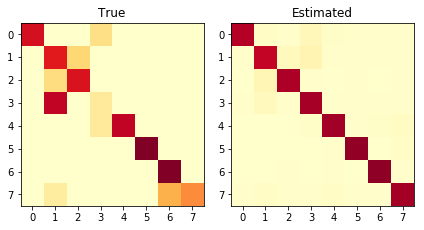

JS divergence: 0.1466	Norm Frobenius: 0.1654
Groups probabilities:  [0. 1.]


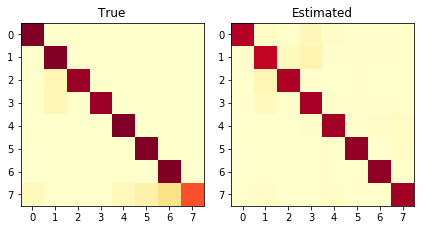

JS divergence: 0.0506	Norm Frobenius: 0.0548
Groups probabilities:  [0. 1.]


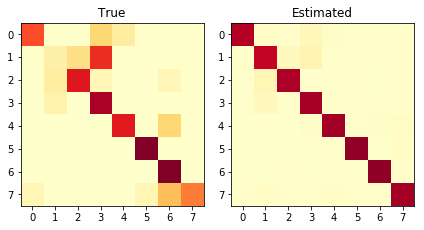

JS divergence: 0.1425	Norm Frobenius: 0.1529
Groups probabilities:  [0. 1.]


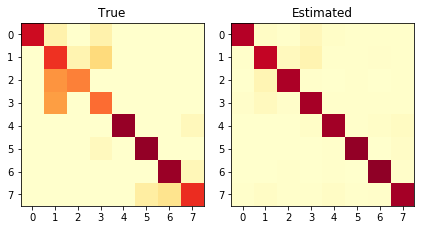

JS divergence: 0.0858	Norm Frobenius: 0.1085
Groups probabilities:  [0. 1.]


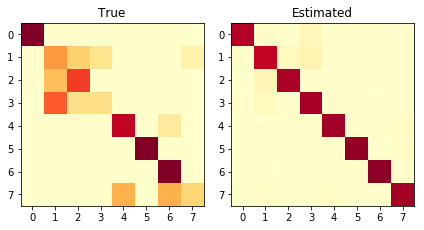

JS divergence: 0.1743	Norm Frobenius: 0.1761
Groups probabilities:  [0. 1.]


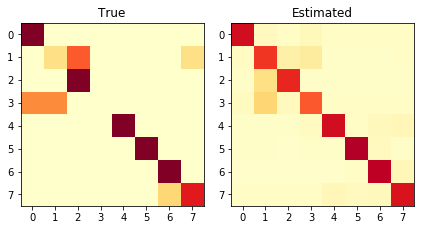

JS divergence: 0.1989	Norm Frobenius: 0.1516
Groups probabilities:  [1. 0.]


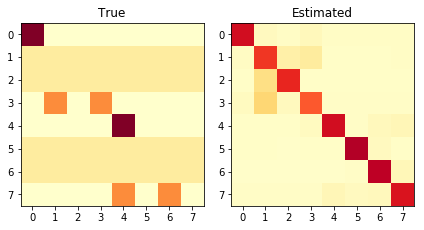

JS divergence: 0.3433	Norm Frobenius: 0.2267
Groups probabilities:  [1. 0.]


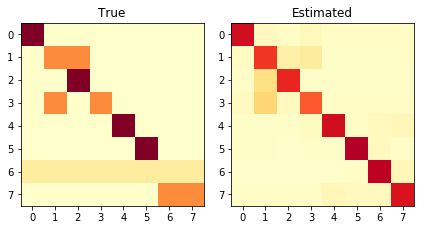

JS divergence: 0.1847	Norm Frobenius: 0.1496
Groups probabilities:  [1. 0.]


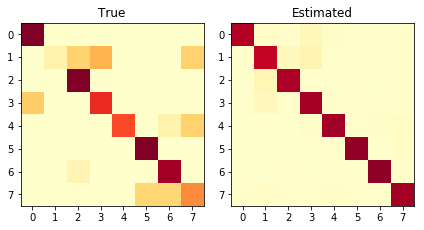

JS divergence: 0.1605	Norm Frobenius: 0.1478
Groups probabilities:  [0. 1.]


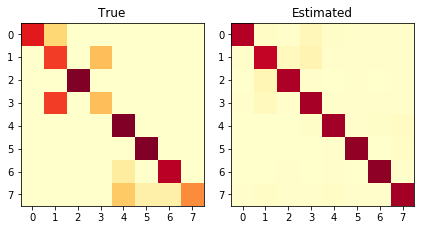

JS divergence: 0.1270	Norm Frobenius: 0.1390
Groups probabilities:  [0. 1.]
Calculate confusion matrix on global version


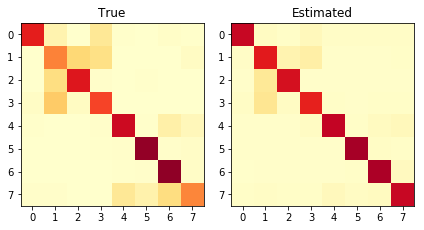

JS divergence: 0.0466	Norm Frobenius: 0.0699
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.852       0.852          0.1776       0.2199       0.1393   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0    0.1431     0.0699  0.0466     0.1469  0.1076

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.7915              0.6186                   0.8233   

   Cross entropy wmean  
0               0.5339

Test


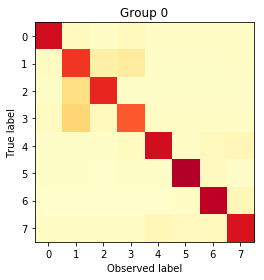

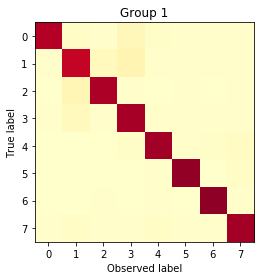

Inertia JS: 0.03860391413997662
Inertia NormF: 0.06940804228463358
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.5932    34   0.8650     0.7700     0.8720    0.7372  0.0334   
1       1  0.4068    24   0.3981     0.9182     0.9576    0.9065  0.0102   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.0386      0.0694    0.8283      0.8283  
1       3   0.0386      0.0694    0.8274      0.8274

A result


Accuracy  F1 (micro)
0  All    0.8266      0.8266

In [25]:
evaluate = Evaluation_metrics(gMixture_Ind2,'our1') 
aux = gMixture_Ind2.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind2.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual2 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind2.get_confusionM()
y_o_groups = gMixture_Ind2.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individua3l multiples runs***
Train
Calculate confusion matrix on repeat version


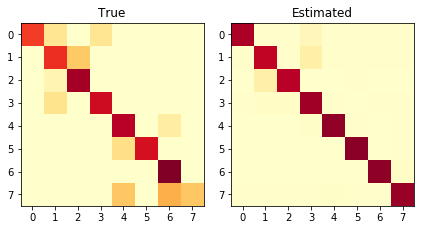

JS divergence: 0.1289	Norm Frobenius: 0.1241
Groups probabilities:  [0. 1.]


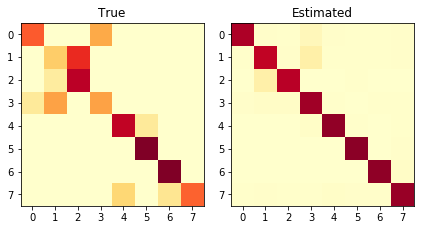

JS divergence: 0.1608	Norm Frobenius: 0.1647
Groups probabilities:  [0. 1.]


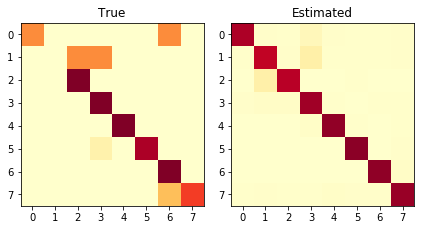

JS divergence: 0.1811	Norm Frobenius: 0.1664
Groups probabilities:  [0. 1.]


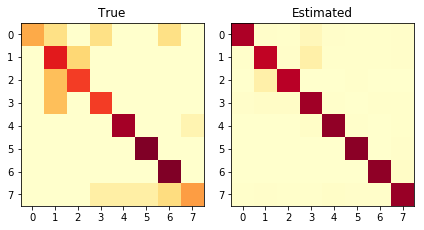

JS divergence: 0.1299	Norm Frobenius: 0.1276
Groups probabilities:  [0. 1.]


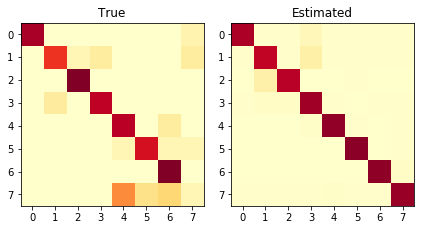

JS divergence: 0.1470	Norm Frobenius: 0.1411
Groups probabilities:  [0. 1.]


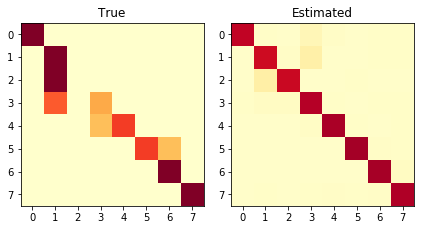

JS divergence: 0.2111	Norm Frobenius: 0.1966
Groups probabilities:  [0.0586 0.9414]


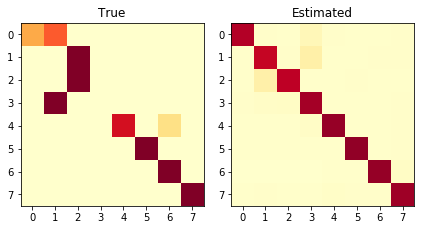

JS divergence: 0.3166	Norm Frobenius: 0.2567
Groups probabilities:  [0.0138 0.9862]


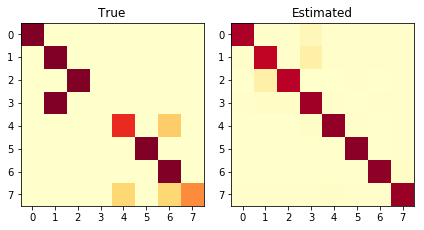

JS divergence: 0.1979	Norm Frobenius: 0.1922
Groups probabilities:  [6.000e-04 9.994e-01]


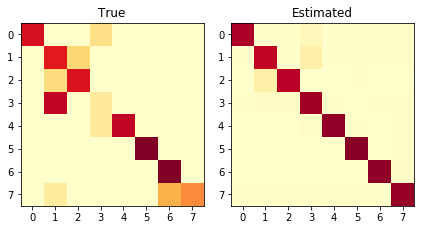

JS divergence: 0.1567	Norm Frobenius: 0.1700
Groups probabilities:  [0. 1.]


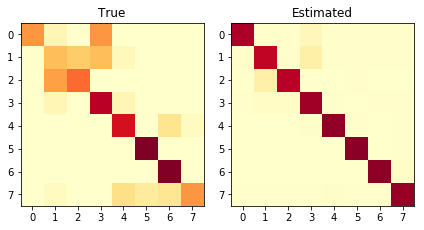

JS divergence: 0.1321	Norm Frobenius: 0.1456
Groups probabilities:  [0. 1.]


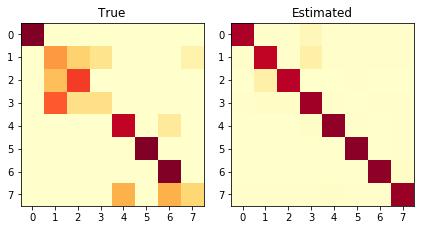

JS divergence: 0.1797	Norm Frobenius: 0.1791
Groups probabilities:  [0. 1.]


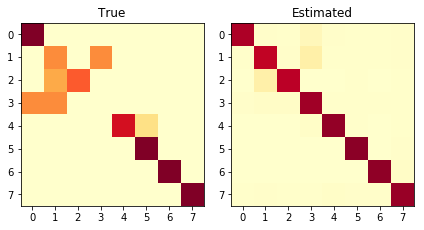

JS divergence: 0.1733	Norm Frobenius: 0.1714
Groups probabilities:  [0.0012 0.9988]


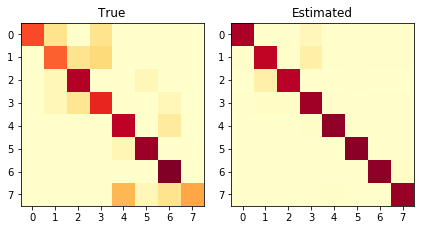

JS divergence: 0.1020	Norm Frobenius: 0.1102
Groups probabilities:  [0. 1.]


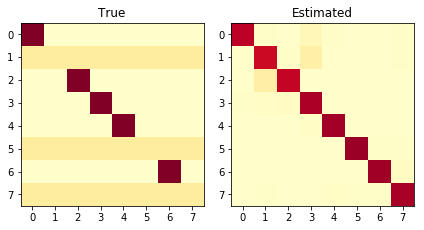

JS divergence: 0.2263	Norm Frobenius: 0.1825
Groups probabilities:  [0.0385 0.9615]


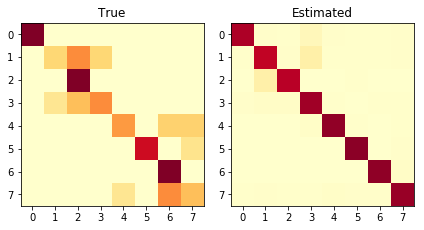

JS divergence: 0.1955	Norm Frobenius: 0.1801
Groups probabilities:  [0. 1.]
Calculate confusion matrix on global version


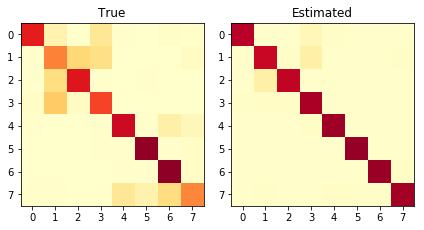

JS divergence: 0.0790	Norm Frobenius: 0.0987
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.824       0.824          0.1941        0.239       0.1477   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0    0.1532     0.0987   0.079     0.1172  0.0899

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.8081              0.5431                   0.8237   

   Cross entropy wmean  
0               0.4922

Test


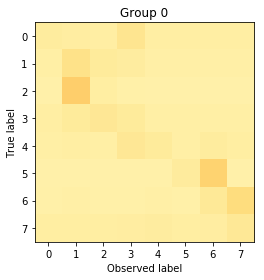

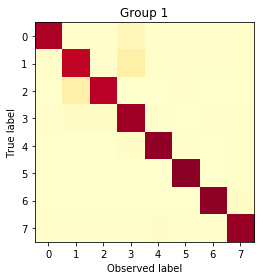

Inertia JS: 0.5392122828072333
Inertia NormF: 0.29820714265322495
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.0291     1   2.0466     0.1441     0.3116    0.0218  0.0232   
1       1  0.9709    57   0.3426     0.9281     0.9627    0.9178  0.0144   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.5392      0.2982    0.2323      0.2323  
1       3   0.5392      0.2982    0.8165      0.8165

A result


Accuracy  F1 (micro)
0  All    0.8199      0.8199

In [20]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individua3l multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

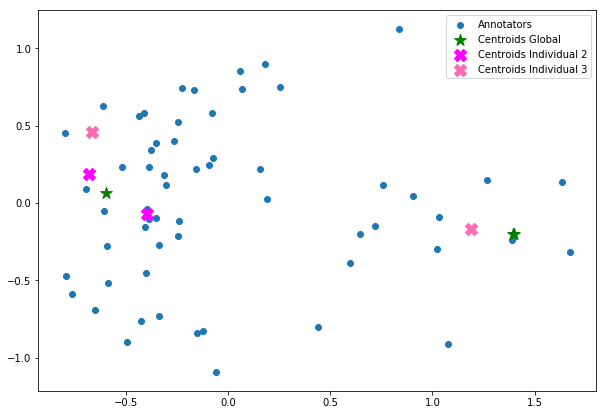

In [51]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()